In [4]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from jupyter_core.migrate import regex


In [5]:
dataset = pd.read_csv('../data/final_dataset_from_scrape.csv')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("display.float_format", "{:.2f}".format)

In [6]:
dataset.shape

(113877, 145)

In [5]:
dataset.info(memory_usage='deep',verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113877 entries, 0 to 113876
Data columns (total 145 columns):
 #    Column                                            Non-Null Count   Dtype  
---   ------                                            --------------   -----  
 0    lat                                               113877 non-null  float64
 1    lon                                               113877 non-null  float64
 2    Unnamed: 0                                        113877 non-null  object 
 3    is_new                                            113877 non-null  bool   
 4    label                                             2025 non-null    object 
 5    model_stub                                        113877 non-null  object 
 6    thumbs                                            111988 non-null  object 
 7    id                                                113877 non-null  int64  
 8    price_debatable                                   113877 non-null  bool 

# From the info of the df we observe a few points:

- we extracted columns 36 to 120 from the field extras and we see the out of all the ads 88612 ads had the field
- we have duplicated columns battery_range and battery charge time. This is because on the scraping based on pagination the field existed and was scraped again in the enrichment phase. We will check that values are the same and deduplicate them.
- short description is missing for all data so we will drop it
- we see that we always have to brand of the car, and 602 ads are missing the model. We will see if we can extract it from another field. Otherwise we might set the model to the name of the brand
- Regarding the descriptions we kept the field in case we can etxract some useful information in the future or for other projects but we will most probably not use it for this project. (Can be used to extract model of the car when missing?)
-  We kept all the fields in extras but for modelling we will only keep the ones we judge most relevant.


In [3]:
dataset.head()

,lat,lon,Unnamed: 0,is_new,label,model_stub,thumbs,id,price_debatable,user_id,...,acceleration,vehicle_width,body_type,vehicle_length,top_speed,trim,wheelbase,fuel_consumption,drive_type,doors
0,40.537681,22.991531,fb208079-b3a1-4187-abe1-c3532386445c,False,NaN,Kia Sportage '02 LIMIDET DERMA FULL EXTRA,"{'count': 7, 'urls': ['https://static.car.gr/1...",11709,True,3027523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Τετρακίνητο (4x4),2.0
1,38.910536,22.333318,8720e225-a56a-434b-bced-82f7c6b7b3df,False,NaN,Mercedes-Benz C 220 '99 CDI DIESEL,"{'count': 8, 'urls': ['https://static.car.gr/2...",22091,False,3026785,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Πισωκίνητο (RWD),4.0
2,40.988597,24.636671,11833766-eca4-436f-8be0-f4f304e5946d,False,NaN,Mercedes-Benz C 180 '00 ELEGANS ΥΠΕΡΠΡΟΣΦΟΡΑ,"{'count': 15, 'urls': ['https://static.car.gr/...",34666,True,1001889,...,12.0,1427.0,sedan,4516.0,193.0,Classic,2690.0,9.2,RWD,5.0
3,40.271180,22.533929,a47702b9-4b30-47aa-8e0c-2bd1bdaa151d,False,NaN,Lincoln Town Car '07 STRECH LIMO TIFFANIS,"{'count': 5, 'urls': ['https://static.car.gr/6...",67361,True,3026787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Πισωκίνητο (RWD),4.0
4,41.093296,23.570392,b8976804-d099-490e-bbcb-d3a9b0971253,False,NaN,Porsche Boxster '02 TIPTRONIC,"{'count': 8, 'urls': ['https://static.car.gr/6...",69173,True,1002754,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Πισωκίνητο (RWD),3.0


In [7]:
dataset.rename({'Unnamed: 0': 'uuid'}, axis=1,inplace=True) #We rename the uuid columns

In [8]:
#Let's check if the ads with a battery range in the first columns are the same ads which display a battery range in the duplicated column

In [9]:
dataset.loc[dataset.battery_range_x.notnull(),['battery_range_x', 'battery_range_y']].head(10)

,battery_range_x,battery_range_y
1623,80 km,80 χλμ
2956,48 km,48 χλμ
3271,50 km,50 χλμ
3291,80 km,80 χλμ
3531,120 km,120 χλμ
3699,100 km,100 χλμ
3725,50 χλμ,50 χλμ
3727,72 km,72 χλμ
3730,530 km,530 χλμ
3760,580 km,580 χλμ


Here we see that the difference between the two columns seem to be the fact that both types are strings with the unit in greek vs latin character. We also see that the units are sometimes in greek and sometimes in english in one of the two columns. Let's extract the numerical value:

In [10]:
dataset.loc[dataset.battery_range_x.notnull(),'battery_range_x'] = dataset.loc[dataset.battery_range_x.notnull(),'battery_range_x'].str.replace(r"(km|χλμ)",'',regex=True).astype(float)

In [11]:
dataset.loc[dataset.battery_range_y.notnull(),'battery_range_y'] = dataset.loc[dataset.battery_range_y.notnull(),'battery_range_y'].str.replace(r"(km|χλμ)",'',regex=True).astype(float)

In [12]:
dataset.loc[dataset.battery_range_x.notnull(),['battery_range_x', 'battery_range_y']].head(10)

,battery_range_x,battery_range_y
1623,80.00,80.00
2956,48.00,48.00
3271,50.00,50.00
3291,80.00,80.00
3531,120.00,120.00
3699,100.00,100.00
3725,50.00,50.00
3727,72.00,72.00
3730,530.00,530.00
3760,580.00,580.00


In [13]:
print(dataset.loc[dataset.battery_range_x.notnull() & dataset.battery_range_y.isna(),['id','battery_range_x', 'battery_range_y']])
print(dataset.loc[dataset.battery_range_x.isna() & dataset.battery_range_y.notnull(),['id','battery_range_x', 'battery_range_y']])

             id battery_range_x battery_range_y
79228  44360874          320.00             NaN
             id battery_range_x battery_range_y
40637  43038506             NaN           50.00


In [14]:
dataset.loc[dataset.battery_range_x.isna() & dataset.battery_range_y.notnull(),'battery_range_x'] = dataset.loc[dataset.battery_range_x.isna() & dataset.battery_range_y.notnull(),'battery_range_y']

dataset.loc[dataset.battery_range_y.isna() & dataset.battery_range_x.notnull(),'battery_range_y'] = dataset.loc[dataset.battery_range_y.isna() & dataset.battery_range_x.notnull(),'battery_range_x']

In [15]:
print(dataset.loc[dataset.battery_range_x.notnull() & dataset.battery_range_y.isna(),['id','battery_range_x', 'battery_range_y']])
print(dataset.loc[dataset.battery_range_x.isna() & dataset.battery_range_y.notnull(),['id','battery_range_x', 'battery_range_y']])

Empty DataFrame
Columns: [id, battery_range_x, battery_range_y]
Index: []
Empty DataFrame
Columns: [id, battery_range_x, battery_range_y]
Index: []


In [16]:
dataset.loc[dataset.battery_range_x.notnull() &(dataset.battery_range_x.ne(dataset.battery_range_y)), ['id','battery_range_x', 'battery_range_y']]

,id,battery_range_x,battery_range_y
26971,42394257,106.00,90.00
64310,43951423,350.00,300.00
64345,43952648,70.00,67.00
75228,44290374,60.00,55.00


We notice some ads (4 ads) where the values differ slightly we will just keep column 6 as we see the difference isn't large and concerns only a few ads.

In [17]:
dataset.drop(columns = ['battery_range_y'], inplace = True)

In [18]:
dataset.rename(columns = {'battery_range_x': 'battery_range'}, inplace = True)

In [19]:
dataset.battery_range.notna().sum()

np.int64(2280)

Let's do the same for the battery charge time

In [20]:
dataset.loc[dataset.battery_charge_time_x.notnull(),['battery_charge_time_x', 'battery_charge_time_y']].head(20)

,battery_charge_time_x,battery_charge_time_y
2956,3 hours,3 ώρες
3271,3 hours,3 ώρες
3531,7 hours,7 ώρες
3699,5 hours / 1 hours,5 ώρες
3730,5 hours,5 ώρες
3780,13 hours / 1 hours,13 ώρες
3870,6 hours / 2 hours,6 ώρες
3985,3 ώρες / 1 ώρες,3 ώρες
4042,7 hours,7 ώρες
4066,5 hours / 3 hours,5 ώρες


We see the difference again the units. Also the first scraped value also shows how many hours in fast charge. We notive that the second columns keeps the normal charging time in consideration. Since we have a higher completion of the normal charging time and for the sake of simplicity we will keep the second column which we will convert to a float. But first we will check if there can be the case where we miss a value in one and not in the other to maximise completion.

In [21]:
print(dataset.loc[dataset.battery_charge_time_x.notna() & dataset.battery_charge_time_y.isna()].shape)
print(dataset.loc[dataset.battery_charge_time_y.notna() & dataset.battery_charge_time_x.isna()].shape)

(0, 144)
(2, 144)


We always have a value in y if x is present so we can safely remove x

In [22]:
dataset.drop(columns=['battery_charge_time_x'],inplace = True)

In [23]:
dataset.battery_charge_time_y = dataset.battery_charge_time_y.str.replace(' ώρες','')

In [24]:
dataset.rename(columns={'battery_charge_time_y': 'battery_charge_time'}, inplace = True)

In [25]:
dataset.battery_charge_time.describe()

count     1041
unique      23
top          5
freq       206
Name: battery_charge_time, dtype: object

In [26]:
dataset.drop(columns=['short_description'],inplace = True)

We have successfully treated the duplicated columns and deleted short description. Let's check the counts of some car brands in the dataset and then check some ads with no mention of the model.

In [27]:
dataset.brand.value_counts()

brand
mercedes-benz    9705
opel             7769
volkswagen       7721
bmw              7242
peugeot          7188
                 ... 
detomaso            1
maybach             1
ac cobra            1
e.go                1
polestar            1
Name: count, Length: 121, dtype: int64

We see that the most present brands on the greek used car market seem to be mercedes, opel and wolkswagen and bmw.

In [28]:
dataset.loc[dataset.model.isna()].head(10)

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,title,without_vat,descriptive_title,seller,created,seo_json_ld,mileage,crashed,address_long,raw_price,engine_size,modified,fueltype,registration_month,registration_year,battery_range,engine_power,fuel_type,gearbox_type,brand,variant,model,year,description,antique,cheques_accepted,turbo,steering_lights,collision_avoidance_system,trip_computer,wheelchair,apple_carplay,credit_card_accepted,extra:827,leather_seats,anti_theft_system_gps,rain_sensor,panoramic_roof,dvd,automatic_parking,warranty_extension,from_organization_of_public_materials_management,multi_purpose_steering_wheel,tcs_asr,tv_camera,seats_7+,power_windows,bucket_seats,hitch,aircondition(a_c),heated_seats,power_seats,alumium_rims,locking_differential,android_auto,accept_exchange_with_car,hardtop,right_hand_drive_car,roof_rails,armored,lane_assist,imported,left_sliding_door,agricultural,never_crashed,immobilizer,notes_accepted,rear_view_camera,air_suspension,bluetooth,leasing,price_without_vat,parktronic,withdrawal_right,isofix_children_seats,electric_sunroof,abs,telephone,led_lights,gps,greek_dealership,automatic_air_conditioning,central_locking,hill_assist,tft_screen,cd_player,warranty,head_up_display,service_book,power_mirrors,eco_start_stop,alarm,taxfree_foreign_numbers,xenon,fog_lights,nonsmoker,power_steering,sliding_doors_x2,radio_player,acc,usb,cruise_control,keyless,price_for_large_families,exchange_with_bike,extra:826,right_sliding_door,exchange_boat_accepted,esp,interior_type,seats,kteo,exterior_color,number_plate_ending,emissions_co2,battery_charge_time,interior_color,rim_size,vehicle_height,number_of_gears,torque,gross_weight,acceleration,vehicle_width,body_type,vehicle_length,top_speed,trim,wheelbase,fuel_consumption,drive_type,doors
9,40.73,23.01,440bec3a-115b-402f-bb04-9ae3a6ac6a1e,False,NaN,Car limousine/sedan '64 VOLGA GAZ21 1964 2.5cc 75Ps.,"{'count': 13, 'urls': ['https://static.car.gr/149969_c_m.jpg', 'https://static.car.gr/149969_r_m.jpg', 'https://static.car.gr/149969_t_m.jpg', 'https://static.car.gr/149969_2_m.jpg', 'https://static.car.gr/149969_6_m.jpg', 'https://static.car.gr/149969_4_m.jpg', 'https://static.car.gr/149969_8_m.jpg', 'https://static.car.gr/149969_n_m.jpg', 'https://static.car.gr/149969_o_m.jpg', 'https://static.car.gr/149969_p_m.jpg', 'https://static.car.gr/149969_q_m.jpg', 'https://static.car.gr/149969_1_m.jpg', 'https://static.car.gr/149969_3_m.jpg']}",149969,False,1004634,Car limousine/sedan '64 VOLGA GAZ21 1964 2.5cc 75Ps.,False,Αυτοκίνητο λιμουζίνα/sedan '64 VOLGA GAZ21 1964 2.5cc 75Ps. - 12/1964 - 93.000 χλμ - Βενζίνη - 2.500 cc - 75 bhp - 4 - Χειροκίνητο - Λιμουζίνα/Sedan,"{'name': '***<<<ALEXCARS>>>***', 'manager_id': 3463, 'address': 'ΛΑΓΥΝΑ-ΛΑΓΚΑΔΑΣ-ΘΕΣΣΑΛΟΝΙΚΗΣ', 'user_since': '2008-12-17 14:39:11', 'verification': {'telephone_verified': False, 'credit_card_verified': False}, 'type': 'Dealer', 'id': 1004634, 'avatar': 'https://static-cz.car.gr/users/3463/ap7xddkj6m.jpeg'}",2009-01-08 12:46:53,"{'url': '/classifieds/cars/view/149969/', '@type': 'Car'}",93000.00,False,LAGKADAS P. THESSALONIKIS 57200,NaN,2500.00,2025-02-03 10:52:08,Petrol,12,1964,NaN,75 bhp,Petrol,NaN,αλλο,volga gaz21 1964 2.5cc 75ps.,NaN,64,ΣΥΛΛΕΚΤΙΚΟ ΜΟΝΑΔΙΚΟ ΓΝΗΣΙΟ ΚΟΜΑΤΙ!!! \r\nΑΝΤΙΚΑ ΒΟΛΓΑ ΓΑΖ-21!!!\r\nΜΟΝΤ.1964.... 2500cc-75Ps...\r\nΔΕΚΤΟΣ ΓΙΑ ΚΑΘΕ ΕΛΕΓΧΟ!!!\r\nΔΕΧΟΜΑΣΤΕ ΑΝΤΑΛΛΑΓΕΣ ΚΑΙ ΠΑΡΑΓΓΕΛΙΕΣ ΑΠΟ ΓΕΡΜΑΝΙΑ!!! \n\nΔείτε το σύνολο των οχημάτων που προσφέρουμε: www.alexcars.gr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00,NaN,Μαύρο,Άγνωστη,20 g/km,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"12,50",Πισωκίνητο (RWD),4.00
10,40.73,23.01,5ea85334-3207-4afc-96ad-ac21e2e5c

We see that these cars are often either old cars, antiques or specific categories such as club cars or limousines, if we compare the year distribution on these cars we can see that they are generally older with a median year model from 1998 vs 2014 on the rest of the cars.

In [29]:
pd.concat([dataset.loc[dataset.model.isna(),'registration_year'].describe(), dataset.loc[dataset.model.notna(),'registration_year'].describe()],axis=1)

,registration_year,registration_year
count,602.00,113275.00
mean,1993.26,2011.61
std,23.74,8.84
min,1917.00,1901.00
25%,1973.25,2007.00
50%,1998.00,2014.00
75%,2016.00,2018.00
max,2026.00,2026.00


In [30]:
dataset[(dataset.model.isna())&(dataset.registration_year>2000)].head(20)

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,title,without_vat,descriptive_title,seller,created,seo_json_ld,mileage,crashed,address_long,raw_price,engine_size,modified,fueltype,registration_month,registration_year,battery_range,engine_power,fuel_type,gearbox_type,brand,variant,model,year,description,antique,cheques_accepted,turbo,steering_lights,collision_avoidance_system,trip_computer,wheelchair,apple_carplay,credit_card_accepted,extra:827,leather_seats,anti_theft_system_gps,rain_sensor,panoramic_roof,dvd,automatic_parking,warranty_extension,from_organization_of_public_materials_management,multi_purpose_steering_wheel,tcs_asr,tv_camera,seats_7+,power_windows,bucket_seats,hitch,aircondition(a_c),heated_seats,power_seats,alumium_rims,locking_differential,android_auto,accept_exchange_with_car,hardtop,right_hand_drive_car,roof_rails,armored,lane_assist,imported,left_sliding_door,agricultural,never_crashed,immobilizer,notes_accepted,rear_view_camera,air_suspension,bluetooth,leasing,price_without_vat,parktronic,withdrawal_right,isofix_children_seats,electric_sunroof,abs,telephone,led_lights,gps,greek_dealership,automatic_air_conditioning,central_locking,hill_assist,tft_screen,cd_player,warranty,head_up_display,service_book,power_mirrors,eco_start_stop,alarm,taxfree_foreign_numbers,xenon,fog_lights,nonsmoker,power_steering,sliding_doors_x2,radio_player,acc,usb,cruise_control,keyless,price_for_large_families,exchange_with_bike,extra:826,right_sliding_door,exchange_boat_accepted,esp,interior_type,seats,kteo,exterior_color,number_plate_ending,emissions_co2,battery_charge_time,interior_color,rim_size,vehicle_height,number_of_gears,torque,gross_weight,acceleration,vehicle_width,body_type,vehicle_length,top_speed,trim,wheelbase,fuel_consumption,drive_type,doors
53,40.27,22.53,e2e1d8a1-c678-4806-880b-b9003fbc7b83,False,NaN,Car other '08 CLUB CAR,"{'count': 3, 'urls': ['https://static.car.gr/1255877_0_m.jpg', 'https://static.car.gr/1255877_1_m.jpg', 'https://static.car.gr/1255877_2_m.jpg']}",1255877,True,3026787,Car other '08 CLUB CAR,False,Αυτοκίνητο άλλο '08 CLUB CAR - 1/2008 - 1 χλμ - Ηλεκτρικό - 0 watt - 10 bhp - 2 - Αυτόματο - Άλλο,"{'name': 'CARPOINT', 'avatar': None, 'verification': {'telephone_verified': False, 'credit_card_verified': False}, 'address': 'L.Iasonidou 119', 'user_since': '2003-01-24 00:16:34', 'type': 'Dealer', 'id': 3026787, 'manager_id': 540}",2011-02-14 13:23:26,"{'url': '/classifieds/cars/view/1255877/', '@type': 'Car'}",1.00,False,KATERINI P. PIERIAS 60100,3900.00,0.00,2025-02-02 21:56:58,Electric,1,2008,NaN,10 bhp,Electric,Automatic,αλλο,club car,NaN,8,"club cart montelo tou 2008 με καινουριες μπαταριες,φορτιστες",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Πράσινο σκούρο,Άγνωστη,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Πισωκίνητο (RWD),2.00
130,38.19,21.72,19430438-1a5d-484c-8ebf-4c497658738e,False,NaN,Car limousine/sedan '04 CENTENNIAL 4.5 V8 LIMO,"{'count': 32, 'urls': ['https://static.car.gr/2153472_g_m.jpg', 'https://static.car.gr/2153472_i_m.jpg', 'https://static.car.gr/2153472_D_m.jpg', 'https://static.car.gr/2153472_16_m.jpg', 'https://static.car.gr/2153472_15_m.jpg', 'https://static.car.gr/2153472_17_m.jpg', 'https://static.car.gr/2153472_5_m.jpg', 'https://static.car.gr/2153472_f_m.jpg', 'https://static.car.gr/2153472_0_m.jpg', 'https://static.car.gr/2153472_14_m.jpg', 'https://static.car.gr/2153472_8_m.jpg', 'https://static.car.gr/2153472_1_m.jpg', 'https://static.car.gr/2153472_3_m.jpg', 'https://static.car.gr/2153472_4_m.jpg', 'https://static.car.gr/2153472_6_m.jpg', 'https://static.car.gr/2153472_2_m.jpg', 'https://static.car.gr/2153472_7_m.jpg', 

We can see from the descriptions that for registration years greater than 2000 we have trailers, limousines, club cars which are all vehicles which do not interest us as we want to focus on usual cars. We can see that a lot of them dont even figure mileage and sometimes a price. We will see how we treat those cases as we can also consider them outliers. What we are sure about is that we will delete the ads without a raw price

In [31]:
dataset[dataset.raw_price.isnull()].shape

(933, 142)

In [32]:
dataset.loc[dataset.raw_price.isnull(),['brand','model','mileage','registration_year','description']].head(20)

,brand,model,mileage,registration_year,description
1,mercedes-benz,c 220,298316.00,1999,"Ο ΚΙΝΗΤΗΡΑΣ ΕΙΝΑΙ ΜΕ 129000 ΧΙΛ ΠΡΩΤΟ ΧΕΡΙ ΑΠΟ ΤΑΞΙ(ΙΔΙΩΤΗΣ),ΚΑΙΝΟΥΡΓΙΑ ΕΛΑΣΤΙΚΑ,ΚΤΕΟ,Κ.Ε.Κ,ΟΛΑ ΤΑ ΣΕΡΒΙΣ ΣΤΗΝ ΩΡΑ ΤΟΥΣ,ΚΑΤΑΝΑΛΩΣΗ 6ΛΙΤΡΑ/100χιλ,ΣΕ ΥΠΕΡΑΡΙΣΤΗ ΚΑΤΑΣΤΑΣΗ."
9,αλλο,NaN,93000.00,1964,ΣΥΛΛΕΚΤΙΚΟ ΜΟΝΑΔΙΚΟ ΓΝΗΣΙΟ ΚΟΜΑΤΙ!!! \r\nΑΝΤΙΚΑ ΒΟΛΓΑ ΓΑΖ-21!!!\r\nΜΟΝΤ.1964.... 2500cc-75Ps...\r\nΔΕΚΤΟΣ ΓΙΑ ΚΑΘΕ ΕΛΕΓΧΟ!!!\r\nΔΕΧΟΜΑΣΤΕ ΑΝΤΑΛΛΑΓΕΣ ΚΑΙ ΠΑΡΑΓΓΕΛΙΕΣ ΑΠΟ ΓΕΡΜΑΝΙΑ!!! \n\nΔείτε το σύνολο των οχημάτων που προσφέρουμε: www.alexcars.gr
10,αλλο,NaN,52863.00,1959,ΣΥΛΛΕΚΤΙΚΟ ΜΟΝΑΔΙΚΟ ΓΝΗΣΙΟ ΚΟΜΑΤI!!!\r\nΑΝΤΙΚΑ ΒΟΛΓΑ ΓΑΖ-21!!! \r\nΜΟΔ.1959. 2500cc-75Ps \r\nΔΕΚΤΟΣ ΓΙΑ ΚΑΘΕ ΕΛΕΓΧΟ!!! ΔΕΧΟΜΑΣΤΕ ΑΝΤΑΛΛΑΓΕΣ ΚΑΙ ΠΑΡΑΓΓΕΛΙΕΣ ΑΠΟ ΓΕΡΜΑΝΙΑ!!!\n\nΔείτε το σύνολο των οχημάτων που προσφέρουμε: www.alexcars.gr
17,mercedes-benz,500,180000.00,1990,"ΖΑΝΤΕΣ ΜΑΕ 9,5Χ18 ΕΜΠΡΟΣ ΚΑΙ 11,5Χ18 ΠΙΣΩ ΕΛΑΣΤΙΚΑ ΚΑΙΝΟΥΡΓΙΑ 245/45/18 ΚΑΙ 285/35/18.FULL FULL EXTRA.ΤΟ ΑΥΤΟΚΙΝΗΤΟ ΕΙΝΑΙ ΓΙΑ ΓΝΩΣΤΕΣ."
31,mercedes-benz,sprinter,51304.00,1996,"ΩΡΕΣ ΛΕΙΤΟΥΡΓΙΑΣ:ΔΕΥΤΕΡΑ-ΠΑΡΑΣΚΕΥΗ 9:00-18:00. \r\nΣΑΒ:10:00-15:00 \r\nΚΥΡΙΑΚΕΣ ΚΑΤΟΠΙΝ ΕΠΙΚΟΙΝΩΝΙΑΣ.ΔΕΝ ΑΠΑΝΤΑΜΕ ΣΕ ΜΗΝΥΜΑΤΑ ΚΑΙ ΣΕ:e-mail. \r\nMercedes-Benz Sprinter 412 D.\r\nEURO 2\r\nABS.\r\nCE.\r\nΕπιτρεπόμενο συνολικό βάρος-Μικτό:4.600 κιλά.\r\nΘέλει Επαγγελματικό Δίπλωμα οδήγησης.\r\nΓΕΡΜΑΝΙΚΟ ΚΑΛΑΘΟΦΟΡΟ RUTHMANN ME CE.\r\n18 ΜΕΤΡΑ ΥΨΟΣ .11 ΜΕΤΡΑ ΠΛΑΓΙΑ.\r\nΔΥΝΑΤΟΤΗΤΑ ΑΝΥΨΩΣΗΣ ΕΩΣ 200 kg ή 2 ΑΤΟΜΩΝ.\r\nΣΕ ΑΡΙΣΤΗ ΚΑΤΑΣΤΑΣΗ.\r\nΠΛΗΡΗ ΛΕΙΤΟΥΡΓΙΑ.\r\n4 ΥΔΡΑΥΛΙΚΑ ΠΟΔΙΑ,ΠΑΝΩ-ΚΑΤΩ ΧΕΙΡΙΣΤΗΡΙΑ ΚΑΛΑΘΙ.\n\nΑΝΤΑΛΛΑΓΗ: \r\nΜε ΙΧ Mercedes Ε , C, A, B...\r\nΔεκτες η προτασεις!!!\n\n• ΔΕΧΟΜΑΣΤΕ ΠΑΡΑΓΓΕΛΙΕΣ ΠΑΝΤΟΣ ΤΥΠΟΥ ΑΥΤΟΚΙΝΗΤΩΝ\r\n• ΔΥΝΑΤΟΤΗΤΑ ΠΑΡΑΔΟΣΗΣ ΣΤΟ ΧΩΡΟ ΣΑΣ\r\n• ΑΝΑΛΑΜΒΑΝΟΥΜΕ ΤΗΝ ΠΩΛΗΣΗ ΤΟΥ ΑΥΤΟΚΙΝΗΤΟΥ ΣΑΣ\r\n• ΓΡΗΓΟΡΗ ΕΞΥΠΗΡΕΤΗΣΗ ΚΑΙ ΑΠΟΛΥΤΗ ΕΧΕΜΥΘΕΙΑ.\n\nΗ εταιρεία ξεκίνησε από την Νυρεμβέργη Γερμανίας το 1972.Η εταιρεία μας εξασφαλίζει τα υψηλότερα επίπεδα ασφάλειας και ποιότητας από το 1972, με εμπειρία και αξιοπιστία πρωτοπορούμε στον χώρο της εισαγωγής και εμπορίας αυτοκινήτων. Για την καλύτερη εξυπηρέτηση του απαιτητικού κοινού, η εταιρεία μας συνεργάζεται με τους μεγαλύτερους οίκους της Ευρώπης και κυρίως της Γερμανίας. Με αυτόν τον τρόπο γίνεται ευκολότερη και οικονομικότερη η εξεύρεση ακόμα και της πιό απαιτητικής παραγγελίας. Οι υπηρεσίες που προσφέρουμε είναι: · Αγορές / Εκτιμήσεις μεταχειρισμένων · Πωλήσεις μεταχειρισμένων · Ανταλλαγές αυτοκινήτων · Εισαγωγές από το εξωτερικό · Εισαγωγές για λογαριασμό τρίτων · Original Book service σε όλα τα αυτοκίνητα · Γραπτή εγγύηση σωστής λειτουργίας ·\n\n*** Η ΠΑΠΑΓΕΩΡΓΙΟΥ Cars-Trucks ΣΑΣ ΜΙΛΑΕΙ ΜΕ ΑΝΟΙΧΤΑ ΧΑΡΤΙΑ ***"
54,mercedes-benz,slk 200,100000.00,2005,"ΑΝΑΒΑΘΜΙΣΗ 1ου ΣΤΑΔΙΟΥ ΜΕ ΤΡΟΧΑΛΙΑ ΚΟΜΠΡΕΣΟΡΑ,ΦΙΛΤΡΟ K&N,ΠΡΟΓΡΑΜΜΑ ΚΑΙ ΒΓΑΖΕΙ 195 ΑΛΟΓΑ.DVD COMAND-APS.ΜΕΜΒΡΑΝΕΣ LLUMAR.ΑΕΡΟΤΟΜΗ. ΠΟΤΗΡΟΘΗΚΗ.ΕΧΩ ΚΑΝΕΙ ΚΑΠΟΙΕΣ ΕΞΩΤΕΡΙΚΕΣ ΠΑΡΕΜΒΑΣΕΙΣ ΟΠΩΣ ΦΑΙΝΟΝΤΑΙ ΣΤΙΣ ΦΩΤΟΓΡΑΦΙΕΣ."
56,volkswagen,golf,5000.00,1987,ΣΕ ΑΡΙΣΤΗ ΚΑΤΑΣΤΑΣΗ ΡΩΤΗΣΤΕ ΤΙΜΗ ΠΩΛΕΙΤΑΙ ΚΑΙ ΣΕ ΚΟΜΑΤΙΑ...
59,nissan,king cab,236541.00,1995,ΑΠΟΣΤΟΛΗ ΣΕ ΟΛΗ ΤΗΝ ΕΛΛΑΔΑ.ΠΙΟ ΠΟΛΛΕΣ ΦΩΤΟΓΡΑΦΙΕΣ ΣΤΟ SARAVALAKI.GR
65,alfa romeo,spider,100.00,1985,NaN
66,lancia,ypsilon,60000.00,2005,NaN


In [33]:
dataset[dataset.raw_price.isnull()].brand.value_counts()

brand
mercedes-benz    101
volkswagen        62
ford              61
bmw               56
audi              48
nissan            44
toyota            44
porsche           40
land rover        35
fiat              33
peugeot           32
opel              30
seat              29
renault           27
citroen           24
skoda             24
αλλο              23
hyundai           20
jeep              17
suzuki            16
kia               16
ferrari           15
alfa romeo        13
dacia             10
mazda             10
mitsubishi         8
honda              7
maserati           6
lexus              6
volvo              5
subaru             5
rover              4
aston martin       4
lancia             4
chevrolet          4
lamborghini        4
cadillac           4
mini               4
piaggio            4
rolls royce        4
saab               3
daihatsu           3
jaguar             3
lada               2
ds                 2
abarth             2
tesla              2
zastava

In [34]:
dataset.shape

(113877, 142)

In [35]:
dataset.dropna(subset=['raw_price'], inplace=True)

In [36]:
dataset.head()

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,title,without_vat,descriptive_title,seller,created,seo_json_ld,mileage,crashed,address_long,raw_price,engine_size,modified,fueltype,registration_month,registration_year,battery_range,engine_power,fuel_type,gearbox_type,brand,variant,model,year,description,antique,cheques_accepted,turbo,steering_lights,collision_avoidance_system,trip_computer,wheelchair,apple_carplay,credit_card_accepted,extra:827,leather_seats,anti_theft_system_gps,rain_sensor,panoramic_roof,dvd,automatic_parking,warranty_extension,from_organization_of_public_materials_management,multi_purpose_steering_wheel,tcs_asr,tv_camera,seats_7+,power_windows,bucket_seats,hitch,aircondition(a_c),heated_seats,power_seats,alumium_rims,locking_differential,android_auto,accept_exchange_with_car,hardtop,right_hand_drive_car,roof_rails,armored,lane_assist,imported,left_sliding_door,agricultural,never_crashed,immobilizer,notes_accepted,rear_view_camera,air_suspension,bluetooth,leasing,price_without_vat,parktronic,withdrawal_right,isofix_children_seats,electric_sunroof,abs,telephone,led_lights,gps,greek_dealership,automatic_air_conditioning,central_locking,hill_assist,tft_screen,cd_player,warranty,head_up_display,service_book,power_mirrors,eco_start_stop,alarm,taxfree_foreign_numbers,xenon,fog_lights,nonsmoker,power_steering,sliding_doors_x2,radio_player,acc,usb,cruise_control,keyless,price_for_large_families,exchange_with_bike,extra:826,right_sliding_door,exchange_boat_accepted,esp,interior_type,seats,kteo,exterior_color,number_plate_ending,emissions_co2,battery_charge_time,interior_color,rim_size,vehicle_height,number_of_gears,torque,gross_weight,acceleration,vehicle_width,body_type,vehicle_length,top_speed,trim,wheelbase,fuel_consumption,drive_type,doors
0,40.54,22.99,fb208079-b3a1-4187-abe1-c3532386445c,False,NaN,Kia Sportage '02 LIMIDET DERMA FULL EXTRA,"{'count': 7, 'urls': ['https://static.car.gr/11709_e_m.jpg', 'https://static.car.gr/11709_g_m.jpg', 'https://static.car.gr/11709_h_m.jpg', 'https://static.car.gr/11709_i_m.jpg', 'https://static.car.gr/11709_k_m.jpg', 'https://static.car.gr/11709_m_m.jpg', 'https://static.car.gr/11709_l_m.jpg']}",11709,True,3027523,Kia Sportage '02 LIMIDET DERMA FULL EXTRA,False,Kia Sportage '02 LIMIDET DERMA FULL EXTRA - 8/2002 - 69.480 χλμ - Βενζίνη - 2.000 cc - 230 bhp - 2 - Χειροκίνητο - Suv/Crossover/4x4,"{'name': '4x4 ΗΡΑΚΛΗΣ Α.Ε', 'avatar': 'https://static-cz.car.gr/users/9/yi7fx46kei.jpeg', 'verification': {'telephone_verified': False, 'credit_card_verified': False}, 'address': 'Λ.ΓΕΩΡΓ.ΣΧΟΛΗΣ 140 ΠΕΡΙΟΧΗ ΙΚΕΑ ΘΕΣ/ΝΙΚΗ ', 'user_since': '2001-08-11 00:16:21', 'type': 'Dealer', 'id': 3027523, 'manager_id': 9}",2008-03-28 11:01:28,"{'url': '/classifieds/cars/view/11709-kia-sportage', '@type': 'Car'}",69480.00,False,THERMI P. THESSALONIKIS 57001,3500.00,2000.00,2025-02-02 21:53:25,Petrol,8,2002,NaN,230 bhp,Petrol,NaN,kia,limidet derma full extra,sportage,2,Με ανταλαγη 3900,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,NaN,5.00,NaN,Γκρι (Μεταλλικό),Άγνωστη,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Τετρακίνητο (4x4),2.00
2,40.99,24.64,11833766-eca4-436f-8be0-f4f304e5946d,False,NaN,Mercedes-Benz C 180 '00 ELEGANS ΥΠΕΡΠΡΟΣΦΟΡΑ,"{'count': 15, 'urls': ['https://static.car.gr/34666_d_m.jpg', 'https://static.car.gr/34666_i_m.jpg', 'https://static.car.gr/34666_e_m.jpg', 'https://static.car.gr/34666_h_m.jpg', 'https://static.car.gr/34666_f_m.jpg', 'https://static.car.gr/34666_n_m.jpg', 'https://static.car.gr/34666_j_m

* We see that the column fueltype has certain categories in latin chars and others in greek.
* We see that engine power is a string (to be converted to number)
* We see that we have second fuel_type that we should drop if same with other one
* We will check gearbox type to see the possible categories
* We will check the brand for duplicates
* we will check the variants
* We see that year of the model is treated as a double digit year to be treated to have year in 4 digit format as the switch from 90's to 00's disrupts the ordinal nature of this value
* For the extras, will we treat a NaN as missing or we will we treat it as a third category na? Which extras will we restrict ourselves to?
* Check interior type categories and uniformise
* Chec seats categories and uniformise
* Check colors and uniformise
* Check number plating distribution and categories and uniformise
* Emissions co2 should be converted to float as it is a string
* Interior color categories to uniformise
* Rimsize to convert to number
* body type check categories and completion
* Check trim categories
* Check fuel consumption types
* Check drivetype possible categories and uniformise
* Check doors



In [37]:
dataset[(dataset.fueltype.notnull() | dataset.fuel_type.notnull()) & (dataset.fuel_type != dataset.fueltype)].shape #fueltype and fuel_type are the same

(0, 142)

In [38]:
dataset.loc[:,['fuel_type','raw_price']].groupby(by=['fuel_type']).agg('median')

,raw_price
fuel_type,
Diesel,13300.00
Electric,22550.00
Gas/lpg,5500.00
Hybrid diesel,45650.00
Hybrid petrol,22775.00
Hydrogen,29990.00
Natural gas(cng),9500.00
Other,5000.00
Petrol,8990.00


In [39]:
dataset.drop(columns=['fueltype'],inplace=True) #we drop the duplicated column

Now we see some ads with Petrol and some with Βενζινη which are the same so we will regroup the greek versions under the english naming for petrol and diesel. We will also group together (Gas/lpg with Natural gas, Αεριο) and we will group hybrid petrol with plug in hybrid petrol as hybrid petrol

In [40]:
dataset.fuel_type.unique()

array(['Petrol', 'Βενζίνη', 'Diesel', 'Electric', 'Αέριο(lpg) - βενζίνη',
       'Άλλο', 'Gas/lpg', 'Πετρέλαιο', 'Hybrid petrol',
       'Υβριδικό βενζίνη', 'Ηλεκτρικό', 'Natural gas(cng)',
       'Υβριδικό πετρέλαιο', 'Φυσικό αέριο(cng) - βενζίνη',
       'Hybrid diesel', 'Other', 'Plug-in hybrid petrol',
       'Υβριδικό plug-in βενζίνη', 'Plug-in hybrid diesel',
       'Υβριδικό plug-in πετρέλαιο', 'Υδρογόνο', 'Hydrogen'], dtype=object)

In [41]:
dataset[dataset.fuel_type == 'Petrol'].head()

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,title,without_vat,descriptive_title,seller,created,seo_json_ld,mileage,crashed,address_long,raw_price,engine_size,modified,registration_month,registration_year,battery_range,engine_power,fuel_type,gearbox_type,brand,variant,model,year,description,antique,cheques_accepted,turbo,steering_lights,collision_avoidance_system,trip_computer,wheelchair,apple_carplay,credit_card_accepted,extra:827,leather_seats,anti_theft_system_gps,rain_sensor,panoramic_roof,dvd,automatic_parking,warranty_extension,from_organization_of_public_materials_management,multi_purpose_steering_wheel,tcs_asr,tv_camera,seats_7+,power_windows,bucket_seats,hitch,aircondition(a_c),heated_seats,power_seats,alumium_rims,locking_differential,android_auto,accept_exchange_with_car,hardtop,right_hand_drive_car,roof_rails,armored,lane_assist,imported,left_sliding_door,agricultural,never_crashed,immobilizer,notes_accepted,rear_view_camera,air_suspension,bluetooth,leasing,price_without_vat,parktronic,withdrawal_right,isofix_children_seats,electric_sunroof,abs,telephone,led_lights,gps,greek_dealership,automatic_air_conditioning,central_locking,hill_assist,tft_screen,cd_player,warranty,head_up_display,service_book,power_mirrors,eco_start_stop,alarm,taxfree_foreign_numbers,xenon,fog_lights,nonsmoker,power_steering,sliding_doors_x2,radio_player,acc,usb,cruise_control,keyless,price_for_large_families,exchange_with_bike,extra:826,right_sliding_door,exchange_boat_accepted,esp,interior_type,seats,kteo,exterior_color,number_plate_ending,emissions_co2,battery_charge_time,interior_color,rim_size,vehicle_height,number_of_gears,torque,gross_weight,acceleration,vehicle_width,body_type,vehicle_length,top_speed,trim,wheelbase,fuel_consumption,drive_type,doors
0,40.54,22.99,fb208079-b3a1-4187-abe1-c3532386445c,False,NaN,Kia Sportage '02 LIMIDET DERMA FULL EXTRA,"{'count': 7, 'urls': ['https://static.car.gr/11709_e_m.jpg', 'https://static.car.gr/11709_g_m.jpg', 'https://static.car.gr/11709_h_m.jpg', 'https://static.car.gr/11709_i_m.jpg', 'https://static.car.gr/11709_k_m.jpg', 'https://static.car.gr/11709_m_m.jpg', 'https://static.car.gr/11709_l_m.jpg']}",11709,True,3027523,Kia Sportage '02 LIMIDET DERMA FULL EXTRA,False,Kia Sportage '02 LIMIDET DERMA FULL EXTRA - 8/2002 - 69.480 χλμ - Βενζίνη - 2.000 cc - 230 bhp - 2 - Χειροκίνητο - Suv/Crossover/4x4,"{'name': '4x4 ΗΡΑΚΛΗΣ Α.Ε', 'avatar': 'https://static-cz.car.gr/users/9/yi7fx46kei.jpeg', 'verification': {'telephone_verified': False, 'credit_card_verified': False}, 'address': 'Λ.ΓΕΩΡΓ.ΣΧΟΛΗΣ 140 ΠΕΡΙΟΧΗ ΙΚΕΑ ΘΕΣ/ΝΙΚΗ ', 'user_since': '2001-08-11 00:16:21', 'type': 'Dealer', 'id': 3027523, 'manager_id': 9}",2008-03-28 11:01:28,"{'url': '/classifieds/cars/view/11709-kia-sportage', '@type': 'Car'}",69480.00,False,THERMI P. THESSALONIKIS 57001,3500.00,2000.00,2025-02-02 21:53:25,8,2002,NaN,230 bhp,Petrol,NaN,kia,limidet derma full extra,sportage,2,Με ανταλαγη 3900,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,NaN,5.00,NaN,Γκρι (Μεταλλικό),Άγνωστη,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Τετρακίνητο (4x4),2.00
2,40.99,24.64,11833766-eca4-436f-8be0-f4f304e5946d,False,NaN,Mercedes-Benz C 180 '00 ELEGANS ΥΠΕΡΠΡΟΣΦΟΡΑ,"{'count': 15, 'urls': ['https://static.car.gr/34666_d_m.jpg', 'https://static.car.gr/34666_i_m.jpg', 'https://static.car.gr/34666_e_m.jpg', 'https://static.car.gr/34666_h_m.jpg', 'https://static.car.gr/34666_f_m.jpg', 'https://static.car.gr/34666_n_m.jpg', 'https://static.car.gr/34666_j_m.jpg', 'https://

In [42]:
dataset[dataset.fuel_type == 'Petrol'].head()

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,title,without_vat,descriptive_title,seller,created,seo_json_ld,mileage,crashed,address_long,raw_price,engine_size,modified,registration_month,registration_year,battery_range,engine_power,fuel_type,gearbox_type,brand,variant,model,year,description,antique,cheques_accepted,turbo,steering_lights,collision_avoidance_system,trip_computer,wheelchair,apple_carplay,credit_card_accepted,extra:827,leather_seats,anti_theft_system_gps,rain_sensor,panoramic_roof,dvd,automatic_parking,warranty_extension,from_organization_of_public_materials_management,multi_purpose_steering_wheel,tcs_asr,tv_camera,seats_7+,power_windows,bucket_seats,hitch,aircondition(a_c),heated_seats,power_seats,alumium_rims,locking_differential,android_auto,accept_exchange_with_car,hardtop,right_hand_drive_car,roof_rails,armored,lane_assist,imported,left_sliding_door,agricultural,never_crashed,immobilizer,notes_accepted,rear_view_camera,air_suspension,bluetooth,leasing,price_without_vat,parktronic,withdrawal_right,isofix_children_seats,electric_sunroof,abs,telephone,led_lights,gps,greek_dealership,automatic_air_conditioning,central_locking,hill_assist,tft_screen,cd_player,warranty,head_up_display,service_book,power_mirrors,eco_start_stop,alarm,taxfree_foreign_numbers,xenon,fog_lights,nonsmoker,power_steering,sliding_doors_x2,radio_player,acc,usb,cruise_control,keyless,price_for_large_families,exchange_with_bike,extra:826,right_sliding_door,exchange_boat_accepted,esp,interior_type,seats,kteo,exterior_color,number_plate_ending,emissions_co2,battery_charge_time,interior_color,rim_size,vehicle_height,number_of_gears,torque,gross_weight,acceleration,vehicle_width,body_type,vehicle_length,top_speed,trim,wheelbase,fuel_consumption,drive_type,doors
0,40.54,22.99,fb208079-b3a1-4187-abe1-c3532386445c,False,NaN,Kia Sportage '02 LIMIDET DERMA FULL EXTRA,"{'count': 7, 'urls': ['https://static.car.gr/11709_e_m.jpg', 'https://static.car.gr/11709_g_m.jpg', 'https://static.car.gr/11709_h_m.jpg', 'https://static.car.gr/11709_i_m.jpg', 'https://static.car.gr/11709_k_m.jpg', 'https://static.car.gr/11709_m_m.jpg', 'https://static.car.gr/11709_l_m.jpg']}",11709,True,3027523,Kia Sportage '02 LIMIDET DERMA FULL EXTRA,False,Kia Sportage '02 LIMIDET DERMA FULL EXTRA - 8/2002 - 69.480 χλμ - Βενζίνη - 2.000 cc - 230 bhp - 2 - Χειροκίνητο - Suv/Crossover/4x4,"{'name': '4x4 ΗΡΑΚΛΗΣ Α.Ε', 'avatar': 'https://static-cz.car.gr/users/9/yi7fx46kei.jpeg', 'verification': {'telephone_verified': False, 'credit_card_verified': False}, 'address': 'Λ.ΓΕΩΡΓ.ΣΧΟΛΗΣ 140 ΠΕΡΙΟΧΗ ΙΚΕΑ ΘΕΣ/ΝΙΚΗ ', 'user_since': '2001-08-11 00:16:21', 'type': 'Dealer', 'id': 3027523, 'manager_id': 9}",2008-03-28 11:01:28,"{'url': '/classifieds/cars/view/11709-kia-sportage', '@type': 'Car'}",69480.00,False,THERMI P. THESSALONIKIS 57001,3500.00,2000.00,2025-02-02 21:53:25,8,2002,NaN,230 bhp,Petrol,NaN,kia,limidet derma full extra,sportage,2,Με ανταλαγη 3900,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,NaN,5.00,NaN,Γκρι (Μεταλλικό),Άγνωστη,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Τετρακίνητο (4x4),2.00
2,40.99,24.64,11833766-eca4-436f-8be0-f4f304e5946d,False,NaN,Mercedes-Benz C 180 '00 ELEGANS ΥΠΕΡΠΡΟΣΦΟΡΑ,"{'count': 15, 'urls': ['https://static.car.gr/34666_d_m.jpg', 'https://static.car.gr/34666_i_m.jpg', 'https://static.car.gr/34666_e_m.jpg', 'https://static.car.gr/34666_h_m.jpg', 'https://static.car.gr/34666_f_m.jpg', 'https://static.car.gr/34666_n_m.jpg', 'https://static.car.gr/34666_j_m.jpg', 'https://

Now we see some ads with Petrol and some with Βενζινη which are the same so we will regroup the greek versions under the english naming. We will make the following groups:

* Petrol: Βενζίνη, Petrol,
* Diesel: Πετρέλαιο, Diesel
* Electric: Ηλεκτρικό, Electric
* Lpg: Αέριο(lpg) - βενζίνη, Gas/lpg
* Hybrid petrol: Hybrid petrol, Υβριδικό βενζίνη
* Hybrid diesel: Hybrid diesel, Υβριδικό πετρέλαιο
* Natural gas: Natural gas(cng), Φυσικό αέριο(cng) - βενζίνη
* Other: Other, Άλλο
* Plug-in hybrid diesel: Plug-in hybrid diesel,  Υβριδικό plug-in πετρέλαιο
* Plug-in hybrid petrol: Υβριδικό plug-in βενζίνη, Plug-in hybrid petrol
* Hydrogen: Hydrogen, Υδρογόνο


In [43]:
dataset.loc[dataset.fuel_type.isin(['Βενζίνη','Petrol']), 'fuel_type'] = 'petrol'
dataset.loc[dataset.fuel_type.isin(['Πετρέλαιο','Diesel']), 'fuel_type'] = 'diesel'
dataset.loc[dataset.fuel_type.isin(['Ηλεκτρικό','Electric']), 'fuel_type'] = 'electric'
dataset.loc[dataset.fuel_type.isin(['Αέριο(lpg) - βενζίνη','Gas/lpg']), 'fuel_type'] = 'lpg'
dataset.loc[dataset.fuel_type.isin(['Hybrid petrol','Υβριδικό βενζίνη']), 'fuel_type'] = 'hybrid_petrol'
dataset.loc[dataset.fuel_type.isin(['Hybrid diesel','Υβριδικό πετρέλαιο']), 'fuel_type'] = 'hybrid_diesel'
dataset.loc[dataset.fuel_type.isin(['Natural gas(cng)','Φυσικό αέριο(cng) - βενζίνη']), 'fuel_type'] = 'cng'
dataset.loc[dataset.fuel_type.isin(['Άλλο','Other']), 'fuel_type'] = 'other'
dataset.loc[dataset.fuel_type.isin(['Υβριδικό plug-in πετρέλαιο','Plug-in hybrid diesel']), 'fuel_type'] = 'plug_in_hybrid_diesel'
dataset.loc[dataset.fuel_type.isin(['Υβριδικό plug-in βενζίνη','Plug-in hybrid petrol']), 'fuel_type'] = 'plug_in_hybrid_petrol'
dataset.loc[dataset.fuel_type.isin(['Υδρογόνο','Hydrogen']), 'fuel_type'] = 'hydrogen'


In [44]:
dataset.fuel_type.unique()

array(['petrol', 'diesel', 'electric', 'lpg', 'other', 'hybrid_petrol',
       'cng', 'hybrid_diesel', 'plug_in_hybrid_petrol',
       'plug_in_hybrid_diesel', 'hydrogen'], dtype=object)

In [45]:
dataset.fuel_type.value_counts()

fuel_type
petrol                   63253
diesel                   35230
lpg                       5891
hybrid_petrol             3497
plug_in_hybrid_petrol     2078
electric                  1366
cng                        707
hybrid_diesel              574
plug_in_hybrid_diesel      293
other                       53
hydrogen                     2
Name: count, dtype: int64

In [46]:
dataset.loc[:,['fuel_type','raw_price']].groupby(by=['fuel_type']).agg('median')

,raw_price
fuel_type,
cng,9300.00
diesel,13000.00
electric,22550.00
hybrid_diesel,45650.00
hybrid_petrol,22790.00
hydrogen,19245.00
lpg,5500.00
other,5000.00
petrol,8700.00


In [47]:
dataset[dataset.fuel_type == 'other'].sort_values(by=['raw_price'], ascending=False).head(10)

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,title,without_vat,descriptive_title,seller,created,seo_json_ld,mileage,crashed,address_long,raw_price,engine_size,modified,registration_month,registration_year,battery_range,engine_power,fuel_type,gearbox_type,brand,variant,model,year,description,antique,cheques_accepted,turbo,steering_lights,collision_avoidance_system,trip_computer,wheelchair,apple_carplay,credit_card_accepted,extra:827,leather_seats,anti_theft_system_gps,rain_sensor,panoramic_roof,dvd,automatic_parking,warranty_extension,from_organization_of_public_materials_management,multi_purpose_steering_wheel,tcs_asr,tv_camera,seats_7+,power_windows,bucket_seats,hitch,aircondition(a_c),heated_seats,power_seats,alumium_rims,locking_differential,android_auto,accept_exchange_with_car,hardtop,right_hand_drive_car,roof_rails,armored,lane_assist,imported,left_sliding_door,agricultural,never_crashed,immobilizer,notes_accepted,rear_view_camera,air_suspension,bluetooth,leasing,price_without_vat,parktronic,withdrawal_right,isofix_children_seats,electric_sunroof,abs,telephone,led_lights,gps,greek_dealership,automatic_air_conditioning,central_locking,hill_assist,tft_screen,cd_player,warranty,head_up_display,service_book,power_mirrors,eco_start_stop,alarm,taxfree_foreign_numbers,xenon,fog_lights,nonsmoker,power_steering,sliding_doors_x2,radio_player,acc,usb,cruise_control,keyless,price_for_large_families,exchange_with_bike,extra:826,right_sliding_door,exchange_boat_accepted,esp,interior_type,seats,kteo,exterior_color,number_plate_ending,emissions_co2,battery_charge_time,interior_color,rim_size,vehicle_height,number_of_gears,torque,gross_weight,acceleration,vehicle_width,body_type,vehicle_length,top_speed,trim,wheelbase,fuel_consumption,drive_type,doors
53590,37.99,23.71,34da43da-c3ca-4991-895c-bef0a154cf01,False,NaN,Car other '24 ΑΔΕΙΑ ΤΑΞΙ,NaN,43646371,False,1001436443,Car other '24 ΑΔΕΙΑ ΤΑΞΙ,False,Αυτοκίνητο άλλο '24 ΑΔΕΙΑ ΤΑΞΙ - 1/2024 - 0 χλμ - Άλλο - 0 cc - 0 bhp - 2 - Χειροκίνητο - Άλλο,"{'name': 'Παναγιώτης ', 'avatar': None, 'address': 'ΑΘΗΝΑ 10441', 'type': 'SingleClassifiedUser', 'id': 1001436443, 'verification': {'telephone_verified': False, 'credit_card_verified': False}}",2025-01-16 18:08:44,"{'url': '/classifieds/cars/view/43646371/', '@type': 'Car'}",0.00,False,ATHINA 10441,125000.00,0.00,2025-02-08 16:01:56,1,2024,NaN,0 bhp,other,NaN,αλλο,αδεια ταξι,NaN,24,100% AΔEIA AΘHNΩN ΠΩΛEITAI (XΩPIΣ OXHMA) 125.000 + EΞOΔA. AΠOΛYTOY METPHTOIΣ. AΠOKΛEIONTAI MEΣITEΣ.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,Άλλο,Άγνωστη,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00
113429,37.88,23.75,ff9d5595-8f70-4aef-b399-786c08643522,False,NaN,Land Rover Range Rover Evoque '20 D I4 180HP S Auto 4WD 2.0,"{'count': 37, 'urls': ['https://static.car.gr/346024866_0_m.jpg', 'https://static.car.gr/346024866_1_m.jpg', 'https://static.car.gr/346024866_2_m.jpg', 'https://static.car.gr/346024866_3_m.jpg', 'https://static.car.gr/346024866_4_m.jpg', 'https://static.car.gr/346024866_5_m.jpg', 'https://static.car.gr/346024866_6_m.jpg', 'https://static.car.gr/346024866_7_m.jpg', 'https://static.car.gr/346024866_8_m.jpg', 'https://static.car.gr/346024866_9_m.jpg', 'https://static.car.gr/346024866_a_m.jpg', 'https://static.car.gr/346024866_b_m.jpg', 'https://static.car.gr/346024866_c_m.jpg', 'https://static.car.gr/346024866_d_m.jpg', 'https://static.car.gr/346024866_e_m.jpg', 'https://static.car.gr/346024866_f_m.jpg', 'https://static.car.gr/346024866_g_m.jpg', 'https://static.car.gr/346024866_h_m.jpg', 'https://static.car.gr/346024866_i_m.jpg', 'https://static.car.gr/346024866_j_m.jpg', 'https://static.car.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'cng'),
  Text(1, 0, 'diesel'),
  Text(2, 0, 'electric'),
  Text(3, 0, 'hybrid_diesel'),
  Text(4, 0, 'hybrid_petrol'),
  Text(5, 0, 'hydrogen'),
  Text(6, 0, 'lpg'),
  Text(7, 0, 'other'),
  Text(8, 0, 'petrol'),
  Text(9, 0, 'plug_in_hybrid_diesel'),
  Text(10, 0, 'plug_in_hybrid_petrol')])

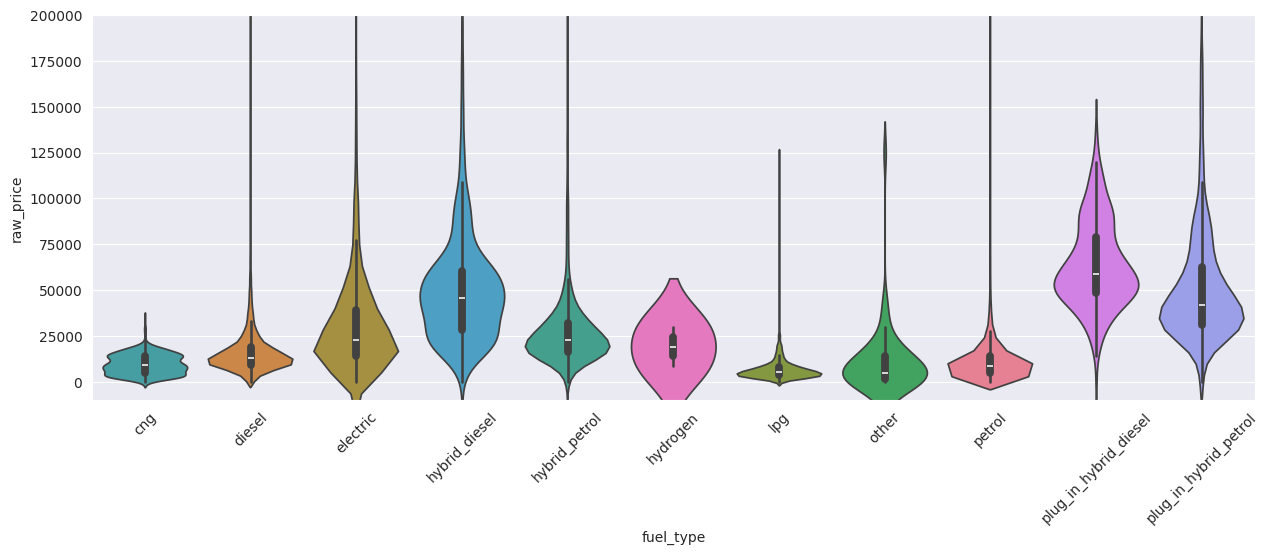

In [48]:
plt.figure(figsize=(15,5))
sns.violinplot(data=dataset,x='fuel_type',y='raw_price',hue='fuel_type',order=sorted(dataset.fuel_type.unique()))
plt.ylim([-10000,200000])
plt.xticks(rotation=45)

In [49]:
#engine power
dataset.engine_power.head(10)

0     230 bhp
2     116 bhp
3     340 bhp
4     224 bhp
5     220 bhp
6     150 bhp
7     100 bhp
8     224 bhp
11    150 bhp
12    126 bhp
Name: engine_power, dtype: object

In [50]:
dataset.engine_power.str.endswith('bhp').sum()/dataset.shape[0] #All the rows are strings ending with bhp we will remove bhp to get the numerical value

np.float64(1.0)

In [51]:
dataset['engine_power'] = dataset.engine_power.str.replace('bhp', '').astype(float)

<Axes: ylabel='Frequency'>

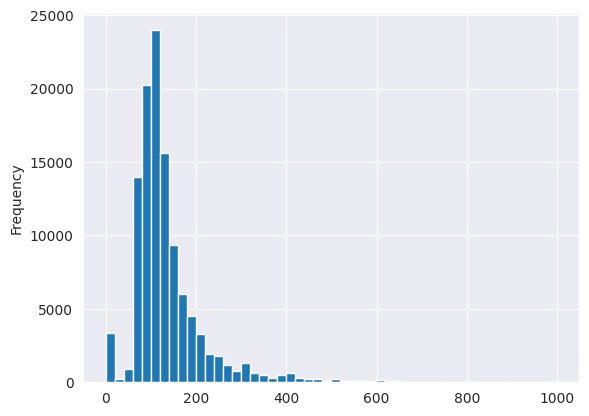

In [52]:
dataset.engine_power.plot(kind='hist', bins=50)

We see 497 ads with 0 horsepower we will replace them as nans as they do seem to concern usual cars

In [53]:
dataset[dataset.engine_power == 0].shape

(497, 141)

In [54]:
dataset[dataset.engine_power == 0].head()

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,title,without_vat,descriptive_title,seller,created,seo_json_ld,mileage,crashed,address_long,raw_price,engine_size,modified,registration_month,registration_year,battery_range,engine_power,fuel_type,gearbox_type,brand,variant,model,year,description,antique,cheques_accepted,turbo,steering_lights,collision_avoidance_system,trip_computer,wheelchair,apple_carplay,credit_card_accepted,extra:827,leather_seats,anti_theft_system_gps,rain_sensor,panoramic_roof,dvd,automatic_parking,warranty_extension,from_organization_of_public_materials_management,multi_purpose_steering_wheel,tcs_asr,tv_camera,seats_7+,power_windows,bucket_seats,hitch,aircondition(a_c),heated_seats,power_seats,alumium_rims,locking_differential,android_auto,accept_exchange_with_car,hardtop,right_hand_drive_car,roof_rails,armored,lane_assist,imported,left_sliding_door,agricultural,never_crashed,immobilizer,notes_accepted,rear_view_camera,air_suspension,bluetooth,leasing,price_without_vat,parktronic,withdrawal_right,isofix_children_seats,electric_sunroof,abs,telephone,led_lights,gps,greek_dealership,automatic_air_conditioning,central_locking,hill_assist,tft_screen,cd_player,warranty,head_up_display,service_book,power_mirrors,eco_start_stop,alarm,taxfree_foreign_numbers,xenon,fog_lights,nonsmoker,power_steering,sliding_doors_x2,radio_player,acc,usb,cruise_control,keyless,price_for_large_families,exchange_with_bike,extra:826,right_sliding_door,exchange_boat_accepted,esp,interior_type,seats,kteo,exterior_color,number_plate_ending,emissions_co2,battery_charge_time,interior_color,rim_size,vehicle_height,number_of_gears,torque,gross_weight,acceleration,vehicle_width,body_type,vehicle_length,top_speed,trim,wheelbase,fuel_consumption,drive_type,doors
228,37.95,23.77,3c8245e1-b5d8-42d4-9847-195dfcdcf2b2,False,NaN,Ford '17 MODEL T TOY 1917,"{'count': 16, 'urls': ['https://static.car.gr/3465936_4_m.jpg', 'https://static.car.gr/3465936_5_m.jpg', 'https://static.car.gr/3465936_n_m.jpg', 'https://static.car.gr/3465936_1_m.jpg', 'https://static.car.gr/3465936_6_m.jpg', 'https://static.car.gr/3465936_7_m.jpg', 'https://static.car.gr/3465936_b_m.jpg', 'https://static.car.gr/3465936_i_m.jpg', 'https://static.car.gr/3465936_j_m.jpg', 'https://static.car.gr/3465936_k_m.jpg', 'https://static.car.gr/3465936_l_m.jpg', 'https://static.car.gr/3465936_m_m.jpg', 'https://static.car.gr/3465936_o_m.jpg', 'https://static.car.gr/3465936_p_m.jpg', 'https://static.car.gr/3465936_q_m.jpg', 'https://static.car.gr/3465936_h_m.jpg']}",3465936,True,1000413,Ford '17 MODEL T TOY 1917,False,Ford '17 MODEL T TOY 1917 - 1/1917 - 0 χλμ - Βενζίνη - 2.500 cc - 0 bhp - 3 - Αυτόματο - Άλλο,"{'name': 'AUTO-MOTO KARAHALIOS', 'manager_id': 1722, 'address': 'Λ.ΑΓ.ΙΩΑΝΝΗ ΚΑΡΕΑ 35 ΒΥΡΩΝΑΣ', 'user_since': '2006-04-20 00:16:39', 'verification': {'telephone_verified': False, 'credit_card_verified': False}, 'type': 'Dealer', 'id': 1000413, 'avatar': None}",2013-03-14 12:26:13,"{'url': '/classifieds/cars/view/3465936-ford', '@type': 'Car'}",0.00,False,VYRWNAS P. ATTIKIS 16233,1.00,2500.00,2025-02-11 11:35:16,1,1917,NaN,0.00,petrol,Automatic,ford,model t toy 1917,NaN,17,ΑΥΤΟΚΙΝΗΤΟ 100 ΕΤΩΝ ΣΕ ΠΛΗΡΗ ΛΕΙΤΟΥΡΓΙΑ ΕΞΑΙΡΕΤΙΚΟ ΜΕ ΠΙΣΤΟΠΟΙΗΤΙΚΑ ΓΝΗΣΙΟΤΗΤΑΣ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00,NaN,Μαύρο,Μονή,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Πισωκίνητο (RWD),3.00
247,40.59,22.19,a9d8c177-e700-41d5-acee-4a6ef16515d2,False,NaN,Smart ForTwo '08 FOR TWO CABRIO DIESEL F1,"{'count': 7, 'urls': ['https://static.car.gr/3810690_3_m.jpg', 'https://static.car.gr/3810690_0_m.jpg', 'https://static.car.gr/3810690_2_m.jpg', 'https://static.car.gr/38

In [55]:
#Gearbox type

In [56]:
dataset.gearbox_type.value_counts()

gearbox_type
Automatic         27376
Αυτόματο           4798
Semi-automatic      488
Ημιαυτόματο         127
Name: count, dtype: int64

We see that the gearbox type is only mentionned for automatic and semi automatic. We want to check if we can consider NaNs as  manual cars and also compare price distributions of automatic vs semi automatic vs nan to see if we can group semi automatic with another category. We also want to group the greek version with the english version as done on fuel type

In [57]:
dataset.loc[dataset.gearbox_type.isin(['Automatic','Αυτόματο']),'gearbox_type'] = 'automatic'
dataset.loc[dataset.gearbox_type.isin(['Semi-automatic','Ημιαυτόματο']),'gearbox_type'] = 'semi_automatic'

In [58]:
dataset.gearbox_type.value_counts()

gearbox_type
automatic         32174
semi_automatic      615
Name: count, dtype: int64

(0.0, 100000.0)

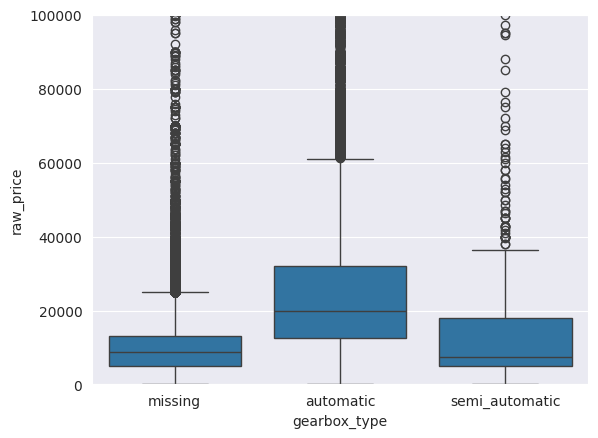

In [59]:
dataset.loc[dataset.gearbox_type.isna(),'gearbox_type'] = 'missing'
sns.boxplot(data=dataset,x='gearbox_type', y= 'raw_price')
plt.ylim([0,100000])

In [60]:
dataset[dataset.gearbox_type == 'missing'].head(10)

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,title,without_vat,descriptive_title,seller,created,seo_json_ld,mileage,crashed,address_long,raw_price,engine_size,modified,registration_month,registration_year,battery_range,engine_power,fuel_type,gearbox_type,brand,variant,model,year,description,antique,cheques_accepted,turbo,steering_lights,collision_avoidance_system,trip_computer,wheelchair,apple_carplay,credit_card_accepted,extra:827,leather_seats,anti_theft_system_gps,rain_sensor,panoramic_roof,dvd,automatic_parking,warranty_extension,from_organization_of_public_materials_management,multi_purpose_steering_wheel,tcs_asr,tv_camera,seats_7+,power_windows,bucket_seats,hitch,aircondition(a_c),heated_seats,power_seats,alumium_rims,locking_differential,android_auto,accept_exchange_with_car,hardtop,right_hand_drive_car,roof_rails,armored,lane_assist,imported,left_sliding_door,agricultural,never_crashed,immobilizer,notes_accepted,rear_view_camera,air_suspension,bluetooth,leasing,price_without_vat,parktronic,withdrawal_right,isofix_children_seats,electric_sunroof,abs,telephone,led_lights,gps,greek_dealership,automatic_air_conditioning,central_locking,hill_assist,tft_screen,cd_player,warranty,head_up_display,service_book,power_mirrors,eco_start_stop,alarm,taxfree_foreign_numbers,xenon,fog_lights,nonsmoker,power_steering,sliding_doors_x2,radio_player,acc,usb,cruise_control,keyless,price_for_large_families,exchange_with_bike,extra:826,right_sliding_door,exchange_boat_accepted,esp,interior_type,seats,kteo,exterior_color,number_plate_ending,emissions_co2,battery_charge_time,interior_color,rim_size,vehicle_height,number_of_gears,torque,gross_weight,acceleration,vehicle_width,body_type,vehicle_length,top_speed,trim,wheelbase,fuel_consumption,drive_type,doors
0,40.54,22.99,fb208079-b3a1-4187-abe1-c3532386445c,False,NaN,Kia Sportage '02 LIMIDET DERMA FULL EXTRA,"{'count': 7, 'urls': ['https://static.car.gr/11709_e_m.jpg', 'https://static.car.gr/11709_g_m.jpg', 'https://static.car.gr/11709_h_m.jpg', 'https://static.car.gr/11709_i_m.jpg', 'https://static.car.gr/11709_k_m.jpg', 'https://static.car.gr/11709_m_m.jpg', 'https://static.car.gr/11709_l_m.jpg']}",11709,True,3027523,Kia Sportage '02 LIMIDET DERMA FULL EXTRA,False,Kia Sportage '02 LIMIDET DERMA FULL EXTRA - 8/2002 - 69.480 χλμ - Βενζίνη - 2.000 cc - 230 bhp - 2 - Χειροκίνητο - Suv/Crossover/4x4,"{'name': '4x4 ΗΡΑΚΛΗΣ Α.Ε', 'avatar': 'https://static-cz.car.gr/users/9/yi7fx46kei.jpeg', 'verification': {'telephone_verified': False, 'credit_card_verified': False}, 'address': 'Λ.ΓΕΩΡΓ.ΣΧΟΛΗΣ 140 ΠΕΡΙΟΧΗ ΙΚΕΑ ΘΕΣ/ΝΙΚΗ ', 'user_since': '2001-08-11 00:16:21', 'type': 'Dealer', 'id': 3027523, 'manager_id': 9}",2008-03-28 11:01:28,"{'url': '/classifieds/cars/view/11709-kia-sportage', '@type': 'Car'}",69480.00,False,THERMI P. THESSALONIKIS 57001,3500.00,2000.00,2025-02-02 21:53:25,8,2002,NaN,230.00,petrol,missing,kia,limidet derma full extra,sportage,2,Με ανταλαγη 3900,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,NaN,5.00,NaN,Γκρι (Μεταλλικό),Άγνωστη,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Τετρακίνητο (4x4),2.00
2,40.99,24.64,11833766-eca4-436f-8be0-f4f304e5946d,False,NaN,Mercedes-Benz C 180 '00 ELEGANS ΥΠΕΡΠΡΟΣΦΟΡΑ,"{'count': 15, 'urls': ['https://static.car.gr/34666_d_m.jpg', 'https://static.car.gr/34666_i_m.jpg', 'https://static.car.gr/34666_e_m.jpg', 'https://static.car.gr/34666_h_m.jpg', 'https://static.car.gr/34666_f_m.jpg', 'https://static.car.gr/34666_n_m.jpg', 'https://static.car.gr/34666_j_m.jpg', 'https

we see that in descriptive title we have the mention "χειροκινητο" so we will extract the presence of this word to determine the manual cars

In [61]:
dataset["is_manual_from_description"] = dataset.descriptive_title.str.lower().str.contains('χειροκίνητο')

In [62]:
dataset[dataset.gearbox_type == 'missing'].shape

(80155, 142)

In [63]:
dataset[dataset.is_manual_from_description].shape

(80155, 142)

we see that we have same number of descriptive title mentionning manual with the number of ads with gearbox missing. Let's check if they are the same rows

In [64]:
dataset[(dataset.gearbox_type == 'missing')&(dataset.is_manual_from_description)].shape

(80155, 142)

In [65]:
dataset[(dataset.gearbox_type != 'missing')&(dataset.is_manual_from_description)].shape

(0, 142)

We see that when the gearbox type was missing it meant that the car is manual, so we will replace the missing gearbox types with the category manual

In [66]:
dataset.loc[dataset.gearbox_type == 'missing', 'gearbox_type'] = 'manual'
dataset.drop(columns=['is_manual_from_description'], inplace=True)

In [67]:
dataset.gearbox_type.value_counts()

gearbox_type
manual            80155
automatic         32174
semi_automatic      615
Name: count, dtype: int64

In [79]:
(dataset.brand.value_counts())

brand
mercedes-benz    9604
opel             7739
volkswagen       7659
bmw              7186
peugeot          7156
                 ... 
detomaso            1
maybach             1
ac cobra            1
e.go                1
polestar            1
Name: count, Length: 121, dtype: int64

We have 121 unique brands

In [82]:
dataset.brand.nunique()

121

In [83]:
brand_counts = dataset.brand.value_counts()

In [85]:
brand_counts[brand_counts>100]

brand
mercedes-benz    9604
opel             7739
volkswagen       7659
bmw              7186
peugeot          7156
toyota           6813
ford             6660
renault          5722
nissan           5467
fiat             5444
citroen          4919
audi             4707
hyundai          4426
suzuki           2729
skoda            2312
seat             2228
mini             2076
smart            1793
kia              1661
jeep             1509
volvo            1442
land rover       1434
alfa romeo       1431
mitsubishi       1403
honda            1219
porsche          1144
mazda            1103
dacia             993
chevrolet         558
subaru            451
jaguar            409
lancia            343
daihatsu          333
daewoo            274
saab              250
isuzu             214
ds                212
lexus             171
mg                139
αλλο              112
lada              106
tesla             105
Name: count, dtype: int64

In [86]:
brand_counts[brand_counts<=100]

brand
rover       100
abarth       98
dodge        97
chrysler     88
maserati     77
           ... 
detomaso      1
maybach       1
ac cobra      1
e.go          1
polestar      1
Name: count, Length: 79, dtype: int64

We see that when having above 100 cars for a brand, it is one of the usual brands found on the european market (based on my humble car knowledge), between 100 and 10 we start to see rarer brands in general luxury brands and below 10 we find some brands that are most probably imported cars by individuals which are not distributed on the territory.

To verify this we can expect a higher median sale price for brands with less than 100 and above 10 ads than the brands with more than 100 ads

In [99]:
pd.concat([dataset.loc[(dataset.groupby(by=['brand'])['brand'].transform('count')<100)& (dataset.groupby(by=['brand'])['brand'].transform('count')>10),'raw_price'].describe(), dataset.loc[(dataset.groupby(by=['brand'])['brand'].transform('count')>=100),'raw_price'].describe()],axis=1).rename(columns={0:'price_rare',1:'price_common'})

,raw_price,raw_price
count,1032.00,111756.00
mean,52258.57,14591.14
std,89587.09,17439.13
min,1.00,1.00
25%,6500.00,6000.00
50%,17975.00,10500.00
75%,49000.00,16990.00
max,690000.00,1111111.00


In [100]:
dataset.columns

Index(['lat', 'lon', 'uuid', 'is_new', 'label', 'model_stub', 'thumbs', 'id',
       'price_debatable', 'user_id',
       ...
       'acceleration', 'vehicle_width', 'body_type', 'vehicle_length',
       'top_speed', 'trim', 'wheelbase', 'fuel_consumption', 'drive_type',
       'doors'],
      dtype='object', length=141)

Interior Type

In [101]:
dataset.interior_type.value_counts()

interior_type
Ύφασμα            37397
Δέρμα             18650
Δέρμα - ύφασμα     8648
Alcantara          3062
Δερματίνη          1424
Βελούδο            1279
Άλλο                714
Name: count, dtype: int64

We see the following categories:
* Fabric
* Leather
* Leather - Fabric
* Alcantara
* Leather again
* Velour
* Other

We will group the 2 redundant leather categories together. Alcantara is a fabric that mimics suede and is considered high end often used in sports cars. We will keep it as is

In [102]:
dataset.loc[dataset.interior_type.isin(['Δέρμα','Δερματίνη']),'interior_type'] = 'leather'
dataset.loc[dataset.interior_type == 'Ύφασμα','interior_type'] = 'fabric'
dataset.loc[dataset.interior_type == 'Δέρμα - ύφασμα','interior_type'] = 'leather_fabric'
dataset.loc[dataset.interior_type == 'Alcantara','interior_type'] = 'alcantara'
dataset.loc[dataset.interior_type == 'Βελούδο','interior_type'] = 'velours'
dataset.loc[dataset.interior_type == 'Άλλο','interior_type'] = 'other'


In [141]:
order = dataset[dataset.groupby('brand').brand.transform('count')>100].groupby(by=["brand"])["raw_price"].median().sort_values(ascending=False).index

In [139]:
order

Index(['lamborghini', 'mclaren', 'lucid', 'ferrari', 'alpina', 'detomaso',
       'ac cobra', 'maybach', 'bentley', 'aston martin',
       ...
       'landwind', 'vauxhall', 'caterham', 'wiesmann', 'austin morris', 'ac',
       'rover', 'daewoo', 'datsun', 'trabant'],
      dtype='object', name='brand', length=121)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41],
 [Text(0, 0, 'porsche'),
  Text(1, 0, 'land rover'),
  Text(2, 0, 'tesla'),
  Text(3, 0, 'jaguar'),
  Text(4, 0, 'ds'),
  Text(5, 0, 'mg'),
  Text(6, 0, 'isuzu'),
  Text(7, 0, 'mercedes-benz'),
  Text(8, 0, 'jeep'),
  Text(9, 0, 'volvo'),
  Text(10, 0, 'bmw'),
  Text(11, 0, 'audi'),
  Text(12, 0, 'lexus'),
  Text(13, 0, 'mini'),
  Text(14, 0, 'dacia'),
  Text(15, 0, 'nissan'),
  Text(16, 0, 'renault'),
  Text(17, 0, 'toyota'),
  Text(18, 0, 'peugeot'),
  Text(19, 0, 'ford'),
  Text(20, 0, 'volkswagen'),
  Text(21, 0, 'hyundai'),
  Text(22, 0, 'kia'),
  Text(23, 0, 'citroen'),
  Text(24, 0, 'skoda'),
  Text(25, 0, 'opel'),
  Text(26, 0, 'mitsubishi'),
  Text(27, 0, 'fiat'),
  Text(28, 0, 'suzuki'),
  Text(29, 0, 'honda'),
  Text(30, 0, 'smart'),
  

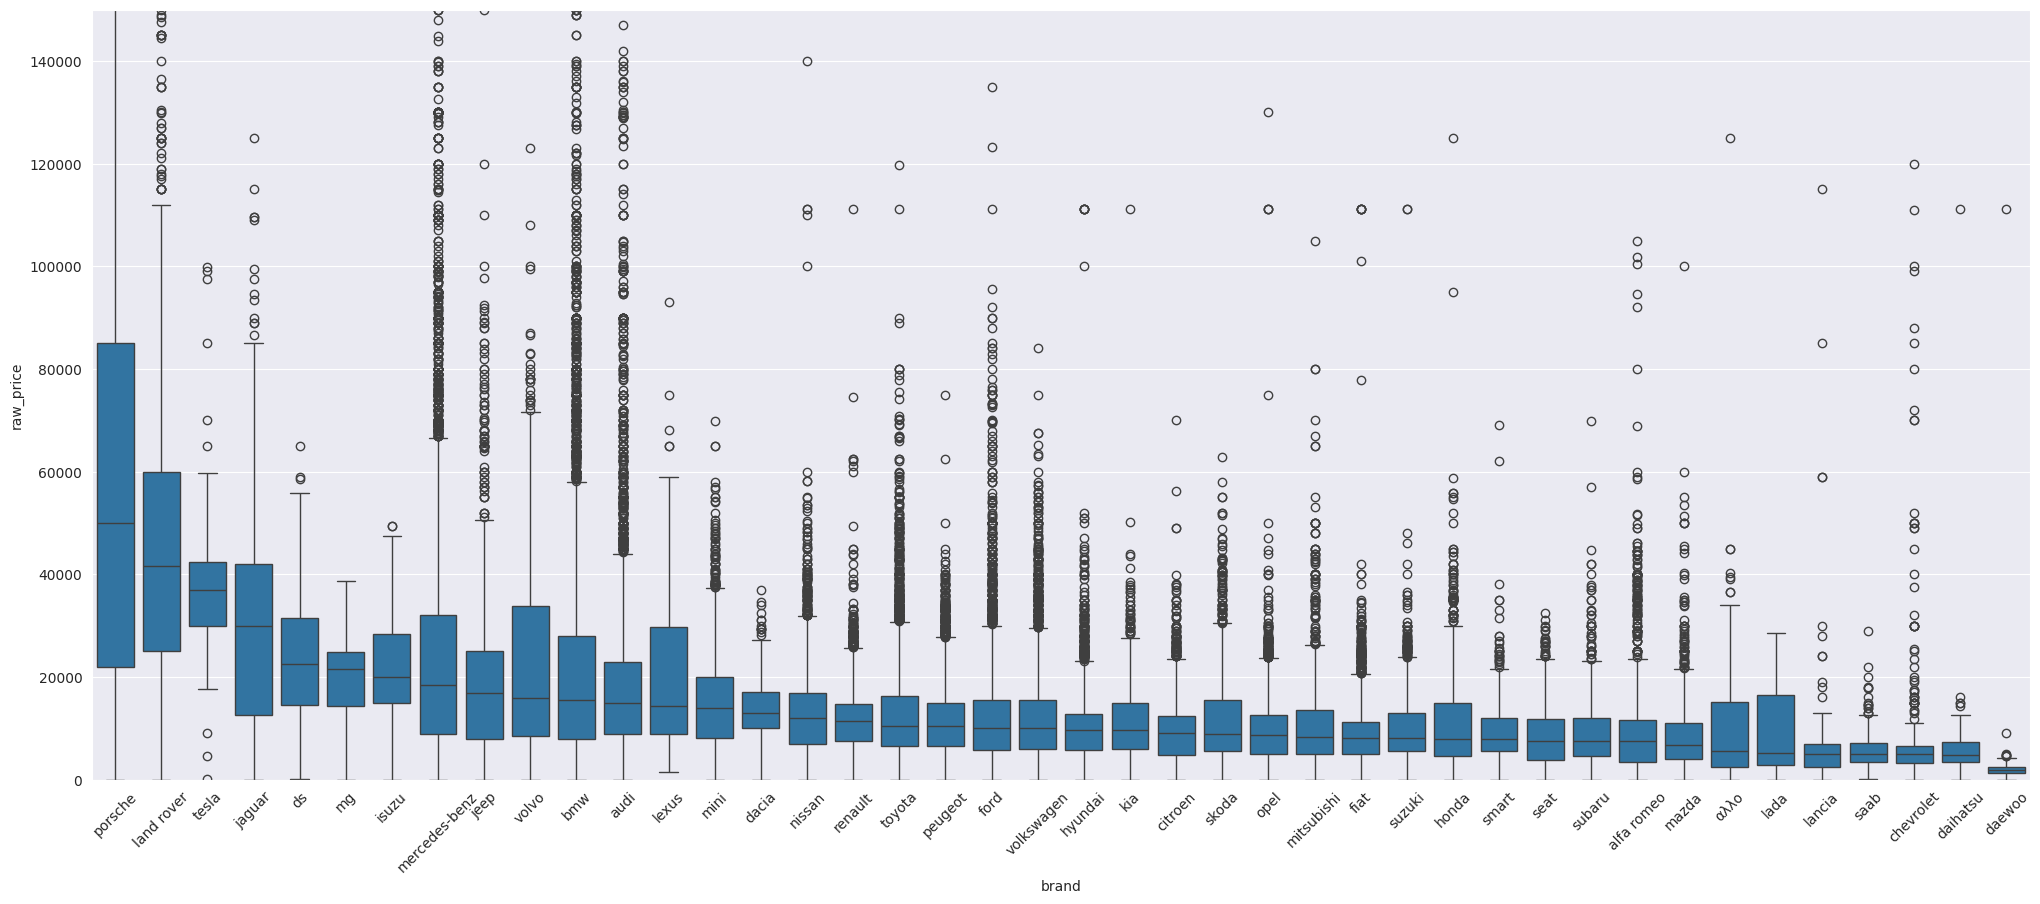

In [142]:
plt.figure(figsize=(25,10))

sns.boxplot(data=dataset[dataset.groupby('brand').brand.transform('count')>100],x='brand', y= 'raw_price', order=order)
plt.ylim([0,150000])
plt.xticks(rotation=45)

In [144]:
dataset.model.unique()

array(['sportage', 'c 180', 'town car', ..., 'clarus', 'm440', 'm850'],
      shape=(1562,), dtype=object)

In [151]:
dataset.loc[dataset.brand == 'bmw'].head(10)

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,title,without_vat,descriptive_title,seller,created,seo_json_ld,mileage,crashed,address_long,raw_price,engine_size,modified,registration_month,registration_year,battery_range,engine_power,fuel_type,gearbox_type,brand,variant,model,year,description,antique,cheques_accepted,turbo,steering_lights,collision_avoidance_system,trip_computer,wheelchair,apple_carplay,credit_card_accepted,extra:827,leather_seats,anti_theft_system_gps,rain_sensor,panoramic_roof,dvd,automatic_parking,warranty_extension,from_organization_of_public_materials_management,multi_purpose_steering_wheel,tcs_asr,tv_camera,seats_7+,power_windows,bucket_seats,hitch,aircondition(a_c),heated_seats,power_seats,alumium_rims,locking_differential,android_auto,accept_exchange_with_car,hardtop,right_hand_drive_car,roof_rails,armored,lane_assist,imported,left_sliding_door,agricultural,never_crashed,immobilizer,notes_accepted,rear_view_camera,air_suspension,bluetooth,leasing,price_without_vat,parktronic,withdrawal_right,isofix_children_seats,electric_sunroof,abs,telephone,led_lights,gps,greek_dealership,automatic_air_conditioning,central_locking,hill_assist,tft_screen,cd_player,warranty,head_up_display,service_book,power_mirrors,eco_start_stop,alarm,taxfree_foreign_numbers,xenon,fog_lights,nonsmoker,power_steering,sliding_doors_x2,radio_player,acc,usb,cruise_control,keyless,price_for_large_families,exchange_with_bike,extra:826,right_sliding_door,exchange_boat_accepted,esp,interior_type,seats,kteo,exterior_color,number_plate_ending,emissions_co2,battery_charge_time,interior_color,rim_size,vehicle_height,number_of_gears,torque,gross_weight,acceleration,vehicle_width,body_type,vehicle_length,top_speed,trim,wheelbase,fuel_consumption,drive_type,doors
11,37.94,23.70,73b97734-e93b-42a4-b722-de0280da8cf4,False,NaN,Bmw 520 '99,"{'count': 2, 'urls': ['https://static.car.gr/229869_0_m.jpg', 'https://static.car.gr/229869_d_m.jpg']}",229869,True,1004469,Bmw 520 '99,False,Bmw 520 '99 - 9/1999 - 112.642 χλμ - Βενζίνη - 2.000 cc - 150 bhp - 4 - Χειροκίνητο - Λιμουζίνα/Sedan,"{'name': 'AUTO ACTION', 'avatar': 'https://static-cz.car.gr/users/1004469/zmpe1xl6l6.jpeg', 'verification': {'telephone_verified': False, 'credit_card_verified': False}, 'address': 'Λ.ΑΜΦΙΘΕΑΣ 8 & ΠΕΝΤΕΛΗΣ 49 ', 'user_since': '2008-11-29 13:53:52', 'type': 'Dealer', 'id': 1004469, 'manager_id': 3407}",2009-04-15 10:24:06,"{'url': '/classifieds/cars/view/229869-bmw-520', '@type': 'Car'}",112642.00,False,NEA SMYRNI P. ATTIKIS 17122,4900.00,2000.00,2025-01-31 04:32:21,9,1999,NaN,150.00,petrol,manual,bmw,NaN,520,99,"ξυλ.επενδυση,antispin.\r\nΕλληνικης αντιπροσωπειας. ΚΑΤΑΣΤΗΜΑ ΚΑΛΑΜΑΤΑΣ",False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False,True,False,False,False,False,False,False,True,NaN,5.00,NaN,Ασημί (Μεταλλικό),Άγνωστη,NaN,NaN,NaN,17 ίντσες,1800.00,5.00,190.00,1980.00,10.20,1435.00,sedan,4775.00,220.00,NaN,2830.00,9.0,RWD,5.00
39,39.20,26.28,7f3b0b7c-9eb0-422f-a31b-4b5096fcb6dd,False,NaN,Bmw 320 '06 226S1 E46,"{'count': 11, 'urls': ['https://static.car.gr/989996_7_m.jpg', 'https://static.car.gr/989996_1_m.jpg', 'https://static.car.gr/989996_6_m.jpg', 'https://static.car.gr/989996_0_m.jpg', 'https://static.car.gr/989996_a_m.jpg', 'https://static.car.gr/989996_5_m.jpg', 'https://static.car.gr/989996_8_m.jpg', 'https://static.car.gr/989996_2_m.jpg', 'https://static.car.gr/989996_9_m.jpg', 'https://static.car.gr/989996_3_m.jpg', 'https://static.car.gr/989996_4_m.jpg']}",989996,True,1001126,Bmw 320 '06 226S1 E46,False,Bmw 320 '06 226S1 E46 - 10/2006 - 85.000 χλμ - Βενζίνη 

In [156]:
dataset.loc[dataset.brand == 'peugeot','model'].unique()

array(['307', '206', '106', '404', 'ion', '306', '205', '104', '107',
       'partner', '5008', '207', '308', 'partner tepee', '406', '604',
       '504', '3008', '304', '208', nan, 'expert', '407', '508', '108',
       '2008', '605', 'rcz', 'bipper', '405', 'rifter', '301', '204',
       'traveller', '1007', '403', '408', 'boxer', '4007', 'bipper tepee',
       'tepee', '807', '309', '4008', '201', 'expert tepee', '806', '607'],
      dtype=object)

### The column Year which corresponds to the model year was a double digit string and we will need to find the corresponding 4 digit year in order to keep the ordinal nature of this variable

Then we will compare the value of the model year to see the cases where this column differs from the registration. This will help us see if the columns give the same information

In [157]:
dataset.year.head()

0     2
2     0
3     7
4     2
5    95
Name: year, dtype: int64

In [166]:
def convert_year_to_4_digits(year):
    if year <= 25:
        return 2000 + year
    else:
        return 1900 + year


In [167]:
dataset['model_year'] = dataset.year.apply(convert_year_to_4_digits)

In [168]:
dataset.model_year.head()

0    2002
2    2000
3    2007
4    2002
5    1995
Name: model_year, dtype: int64

In [172]:
dataset.loc[dataset.model_year != dataset.registration_year,['model_stub','model_year','registration_year']]

,model_stub,model_year,registration_year
228,Ford '17 MODEL T TOY 1917,2017,1917
58209,Honda S 2000 '26,1926,2026
72707,Citroen C3 '26 1.6 16V VTR,1926,2026
74141,"Isuzu Pick up '26 TD 2,5 INTERCOOLER",1926,2026
74951,Skoda '26,1926,2026
79476,Opel Astra '26 F,1926,2026
80764,Toyota Yaris '26 1.4 D-4D DIESEL 6ταχυτο,1926,2026
88714,Jeep Willys '01,2001,1901
104325,Renault '25 6CV,2025,1925



We notice that the method worked well except for 9 ads where we find a registration year different from the model year. What we see is that there are 6 ads where the user mentions the car is from 2026 so the method failed in those cases. Then we encounter three cars dating from 1917, 1901, 1925 and 1925 and where the method failed. We also encounter one car for which the registration year mentioned was wrong. We will therefore keep registration year and drop model year and the initial year column


In [173]:
dataset.drop(columns=['model_year','year'], inplace=True)

## Seats

In [174]:
dataset.seats.isna().sum()

np.int64(36)

count   112908.00
mean         4.73
std          0.90
min          1.00
10%          4.00
20%          5.00
30%          5.00
40%          5.00
50%          5.00
60%          5.00
70%          5.00
80%          5.00
90%          5.00
max         11.00
Name: seats, dtype: float64

In [178]:
dataset.seats.value_counts()


seats
5.00     88308
4.00     13063
2.00      6424
7.00      1918
3.00      1912
9.00       451
6.00       417
8.00       221
1.00       169
11.00       13
10.00       12
Name: count, dtype: int64

Regarding the seats we will restrict ourselves to cars from 2 to 7 seats and consider the rest as outliers based on hard rule. In fact 1 seat car are mostly rally cars which do not interest us. And cars larger than 7 seats are usually mini vans which also won't matter to us for this project as we wish to estimate usual cars

In [183]:
dataset[dataset.seats > 7].sample(5)

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,title,without_vat,descriptive_title,seller,created,seo_json_ld,mileage,crashed,address_long,raw_price,engine_size,modified,registration_month,registration_year,battery_range,engine_power,fuel_type,gearbox_type,brand,variant,model,description,antique,cheques_accepted,turbo,steering_lights,collision_avoidance_system,trip_computer,wheelchair,apple_carplay,credit_card_accepted,extra:827,leather_seats,anti_theft_system_gps,rain_sensor,panoramic_roof,dvd,automatic_parking,warranty_extension,from_organization_of_public_materials_management,multi_purpose_steering_wheel,tcs_asr,tv_camera,seats_7+,power_windows,bucket_seats,hitch,aircondition(a_c),heated_seats,power_seats,alumium_rims,locking_differential,android_auto,accept_exchange_with_car,hardtop,right_hand_drive_car,roof_rails,armored,lane_assist,imported,left_sliding_door,agricultural,never_crashed,immobilizer,notes_accepted,rear_view_camera,air_suspension,bluetooth,leasing,price_without_vat,parktronic,withdrawal_right,isofix_children_seats,electric_sunroof,abs,telephone,led_lights,gps,greek_dealership,automatic_air_conditioning,central_locking,hill_assist,tft_screen,cd_player,warranty,head_up_display,service_book,power_mirrors,eco_start_stop,alarm,taxfree_foreign_numbers,xenon,fog_lights,nonsmoker,power_steering,sliding_doors_x2,radio_player,acc,usb,cruise_control,keyless,price_for_large_families,exchange_with_bike,extra:826,right_sliding_door,exchange_boat_accepted,esp,interior_type,seats,kteo,exterior_color,number_plate_ending,emissions_co2,battery_charge_time,interior_color,rim_size,vehicle_height,number_of_gears,torque,gross_weight,acceleration,vehicle_width,body_type,vehicle_length,top_speed,trim,wheelbase,fuel_consumption,drive_type,doors
72120,38.26,21.74,9caba8fd-63a2-4fb2-9100-de3df15f6355,False,NaN,Renault Trafic '17 TRAFIC DIESEL DCI,"{'count': 14, 'urls': ['https://static.car.gr/44235099_0_m.jpg', 'https://static.car.gr/44235099_1_m.jpg', 'https://static.car.gr/44235099_2_m.jpg', 'https://static.car.gr/44235099_3_m.jpg', 'https://static.car.gr/44235099_4_m.jpg', 'https://static.car.gr/44235099_5_m.jpg', 'https://static.car.gr/44235099_6_m.jpg', 'https://static.car.gr/44235099_7_m.jpg', 'https://static.car.gr/44235099_8_m.jpg', 'https://static.car.gr/44235099_9_m.jpg', 'https://static.car.gr/44235099_a_m.jpg', 'https://static.car.gr/44235099_b_m.jpg', 'https://static.car.gr/44235099_c_m.jpg', 'https://static.car.gr/44235099_d_m.jpg']}",44235099,True,1001683,Renault Trafic '17 TRAFIC DIESEL DCI,False,Renault Trafic '17 TRAFIC DIESEL DCI - 1/2017 - 104.533 χλμ - Πετρέλαιο - 1.600 cc - 95 bhp - 4 - Χειροκίνητο - Van/Mini Bus/Mpv,"{'name': 'AVIS CARS ΠΑΤΡΑΣ', 'avatar': 'https://static-cz.car.gr/users/1001683/1mx2chjyod.jpeg', 'verification': {'telephone_verified': False, 'credit_card_verified': False}, 'address': 'Ηρωων Πολυτεχνειου - Αμερικης', 'user_since': '2011-01-12 14:08:00', 'type': 'Dealer', 'id': 1001683, 'manager_id': 6989}",2025-02-05 11:55:26,"{'url': '/classifieds/cars/view/44235099-renault-trafic', '@type': 'Car'}",104533.00,False,PATRA 26223,29000.00,1600.00,2025-02-05 11:55:26,1,2017,NaN,95.00,diesel,manual,renault,trafic diesel dci,trafic,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,9.00,NaN,Άσπρο,Άγνωστη,NaN,NaN,NaN,NaN,1956.00,6.00,260.00,2760.00,15.90,1971.00,Bus,4999.00,153.00,"Combi 2,7t dCi 95 Start &amp; Stop Authentique",3098.00,6.0,FWD,5.00
31532,37.95,23.67,43791f84-16e7-4f5e-b4e0-295c432b0f21,False,NaN,Mercedes-

## Color

We have 44 colors in the dataset differntiating between metallic color or plain. In order to not have a large number colors as we already have multiple categorical features in this dataset, we will try to group them under main colors. We will check however that the distributions don't differ so much and be careful with the number of observations per categories

In [184]:
dataset.exterior_color.unique()

array(['Γκρι (Μεταλλικό)', 'Μπλε σκούρο (Μεταλλικό)', 'Άσπρο',
       'Μαύρο (Μεταλλικό)', 'Πράσινο σκούρο (Μεταλλικό)', 'Καφέ',
       'Ασημί (Μεταλλικό)', 'Μαύρο', 'Κόκκινο', 'Χρυσαφί (Μεταλλικό)',
       'Κόκκινο σκούρο (Μεταλλικό)', 'Κόκκινο (Μεταλλικό)',
       'Πορτοκαλί (Μεταλλικό)', 'Μπλε (Μεταλλικό)', 'Άλλο', 'Χρυσαφί',
       'Πράσινο', 'Καφέ (Μεταλλικό)', 'Κίτρινο', 'Πράσινο σκούρο', 'Γκρι',
       'Κόκκινο σκούρο', 'Μπλε', 'Ασημί', 'Μπλε σκούρο',
       'Κίτρινο (Μεταλλικό)', 'Γαλάζιο', 'Μπεζ', 'Άλλο (Μεταλλικό)',
       'Άσπρο (Μεταλλικό)', 'Μπορντό (Μεταλλικό)', 'Πράσινο (Μεταλλικό)',
       'Γαλάζιο (Μεταλλικό)', 'Μπεζ (Μεταλλικό)', 'Λεμονί (Μεταλλικό)',
       'Πορτοκαλί', 'Ροζ', 'Μοβ-βιολετί', 'Μπορντό',
       'Μοβ-βιολετί (Μεταλλικό)', 'Ροζ (Μεταλλικό)', 'Λεμονί',
       'Χρώμιο (Μεταλλικό)', 'Χρώμιο', nan], dtype=object)

In [185]:
dataset.exterior_color.nunique()

44

In the below table it seems that for most cases in median, for one color, its metallic version is more expensive than its basic color. And also we observe visually when comparing the boxplots of the raw price per color that the color seems to have an influence on the price. For example odd colors like yellow, pink or bordeau seem to be cheaper. It is also interesting to see the high variance on the color pink with a large interquartile range compared to other colors. To verify these hypothese however we also need to take a look at the prices per manufacturer or model as some car manufacturers have a flagship color for some models which might be valued differently. In any case in order to tackle this in the most efficient manner in the future we will process this variable as follows:

* We will create a new boolean column is_metallic to know if the exterior color is metallic
* Then we will group the colors together (for example white metallic with white)
* We will also translate the colors to english

This way we reduce the number of color levels and won't loose the information about the type of color.

In [196]:
dataset.loc[:,['exterior_color','raw_price']].groupby('exterior_color').agg(['count','median'])

raw_price         
                               count   median
exterior_color                               
Άλλο                             634  7825.00
Άλλο (Μεταλλικό)                 871 11000.00
Άσπρο                          17856 11000.00
Άσπρο (Μεταλλικό)               8777 13900.00
Ασημί                           4123  5300.00
Ασημί (Μεταλλικό)               9267  8300.00
Γαλάζιο                          779  4500.00
Γαλάζιο (Μεταλλικό)             1334  6850.00
Γκρι                            4465 11300.00
Γκρι (Μεταλλικό)               12782 13799.00
Κίτρινο                          527  4800.00
Κίτρινο (Μεταλλικό)              233  9000.00
Καφέ                             301 10900.00
Καφέ (Μεταλλικό)                1052 12500.00
Κόκκινο                         3084  7400.00
Κόκκινο (Μεταλλικό)             1920  9300.00
Κόκκινο σκούρο                   454  6994.50
Κόκκινο σκούρο (Μεταλλικό)       757 11499.00
Λεμονί                            24  6649.50
Λεμονί (Μεταλλικό)                19  7000.00
Μαύρο                           8251  9000.00
Μαύρο (Μεταλλικό)              16765 13000.00
Μοβ-βιολετί                       72  7100.00
Μοβ-βιολετί (Μεταλλικό)          159  8500.00
Μπεζ                             589  9500.00
Μπεζ (Μεταλλικό)                 912 10275.00
Μπλε                            2364  5999.50
Μπλε (Μεταλλικό)                3946 10000.00
Μπλε σκούρο                     1453  5300.00
Μπλε σκούρο (Μεταλλικό)         3297  9900.00
Μπορντό                          461  3450.00
Μπορντό (Μεταλλικό)              931  9450.00
Πορτοκαλί                        269 10500.00
Πορτοκαλί (Μεταλλικό)            509 13900.00
Πράσινο                          647  3800.00
Πράσινο (Μεταλλικό)              682  5800.00
Πράσινο σκούρο                   437  4200.00
Πράσινο σκούρο (Μεταλλικό)       758  7500.00
Ροζ                               13  6900.00
Ροζ (Μεταλλικό)                   13  5900.00
Χρυσαφί                          313  4550.00
Χρυσαφί (Μεταλλικό)              782  7500.00
Χρώμιο                            10 11250.00
Χρώμιο (Μεταλλικό)                47 11400.00

In [193]:
order = dataset.groupby('exterior_color')['raw_price'].agg('median').sort_values(ascending=False).index.tolist()

(0.0, 100000.0)

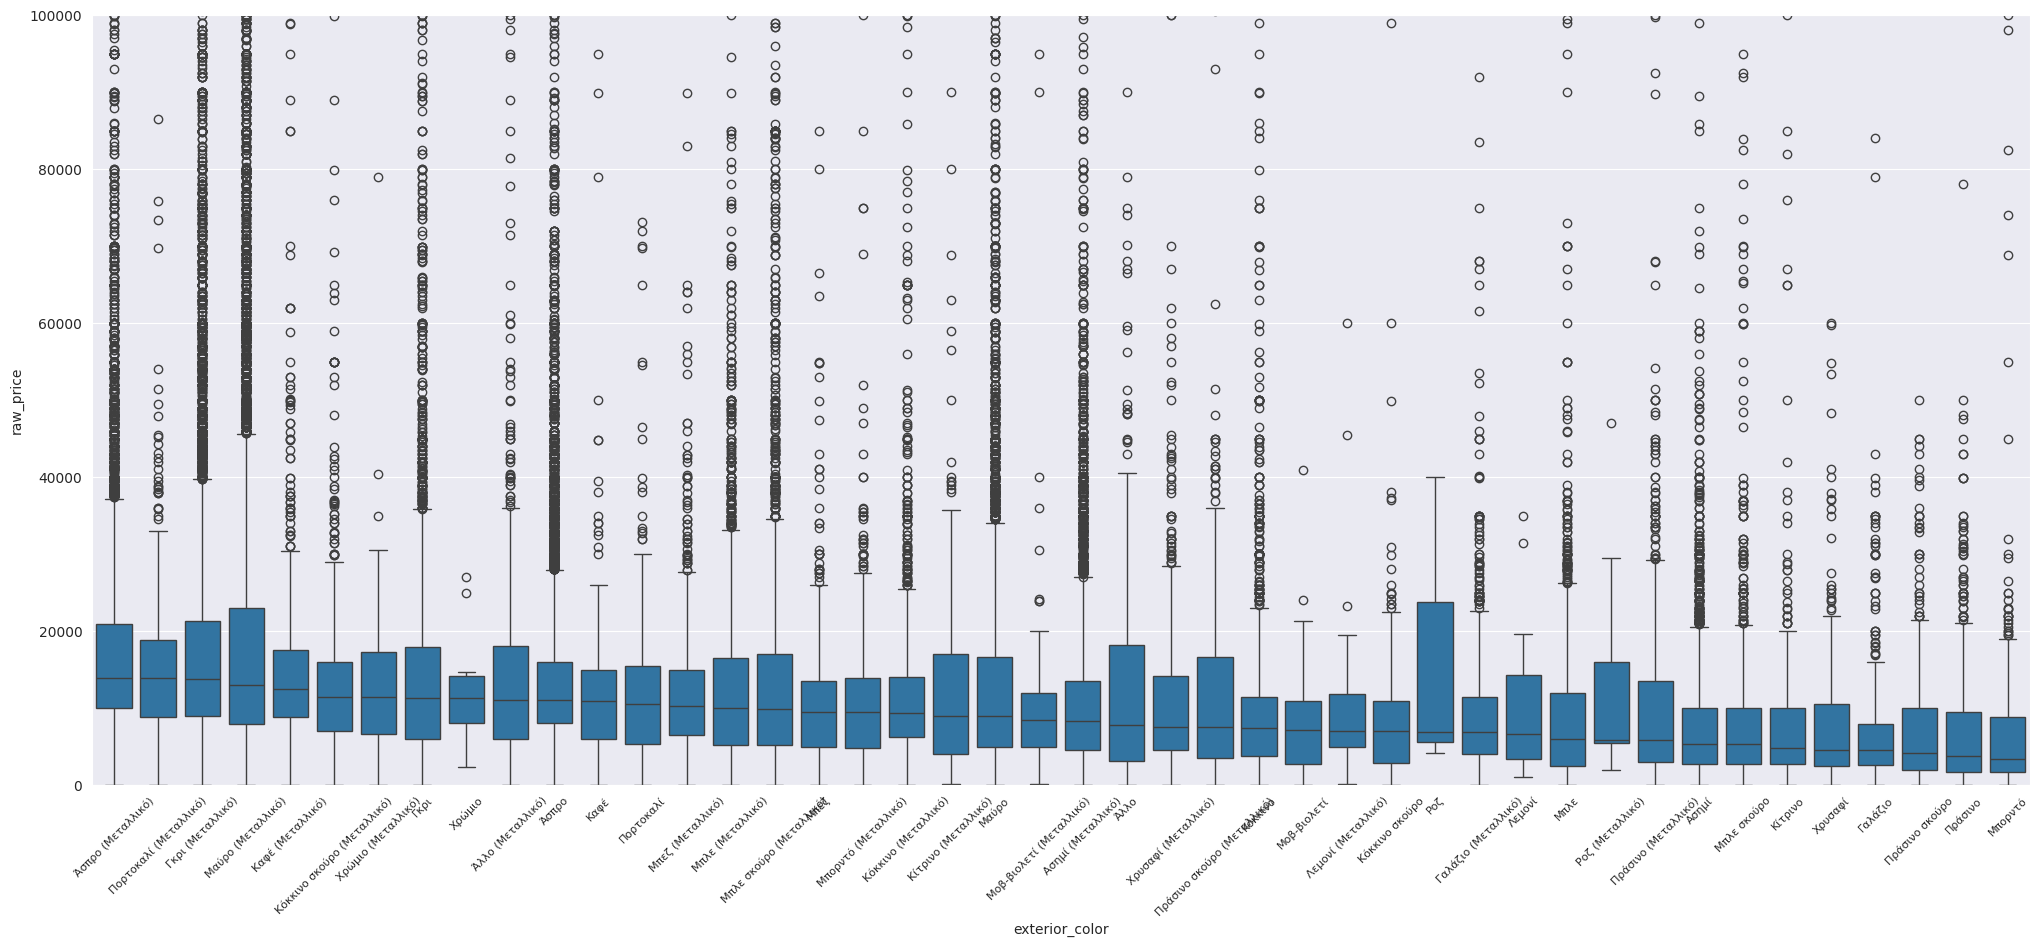

In [195]:
plt.figure(figsize=(25,10))
sns.boxplot(data=dataset, x='exterior_color', y= 'raw_price', order=order)
plt.xticks(rotation=45, fontsize=8)
plt.ylim([0,100000])

In [197]:
dataset['is_metallic'] = dataset.exterior_color.str.contains('Μεταλλικό')

In [208]:
dataset.loc[(~dataset.exterior_color.str.contains('Μεταλλικό',na=False))&(dataset.exterior_color.notna()),'exterior_color'].unique()

array(['Άσπρο', 'Καφέ', 'Μαύρο', 'Κόκκινο', 'Άλλο', 'Χρυσαφί', 'Πράσινο',
       'Κίτρινο', 'Πράσινο σκούρο', 'Γκρι', 'Κόκκινο σκούρο', 'Μπλε',
       'Ασημί', 'Μπλε σκούρο', 'Γαλάζιο', 'Μπεζ', 'Πορτοκαλί', 'Ροζ',
       'Μοβ-βιολετί', 'Μπορντό', 'Λεμονί', 'Χρώμιο'], dtype=object)

In [209]:
car_colors_map = color_translation = {
    'Άσπρο': 'white',
    'Καφέ': 'brown',
    'Μαύρο': 'black',
    'Κόκκινο': 'red',
    'Άλλο': 'other',
    'Χρυσαφί': 'gold',
    'Πράσινο': 'green',
    'Κίτρινο': 'yellow',
    'Πράσινο σκούρο': 'dark_green',
    'Γκρι': 'grey',
    'Κόκκινο σκούρο': 'dark_red',
    'Μπλε': 'blue',
    'Ασημί': 'silver',
    'Μπλε σκούρο': 'dark_blue',
    'Γαλάζιο': 'light_blue',
    'Μπεζ': 'beige',
    'Πορτοκαλί': 'orange',
    'Ροζ': 'pink',
    'Μοβ-βιολετί': 'purple',
    'Μπορντό': 'burgundy',
    'Λεμονί': 'lemon',
    'Χρώμιο': 'chrome'
}

In [211]:
for col in car_colors_map.keys():
    dataset.loc[dataset.exterior_color.str.contains(col,na=False),'exterior_color'] = car_colors_map[col]

In [214]:
dataset.exterior_color.isna().sum()

np.int64(5)

In [215]:
dataset[dataset.exterior_color.isna()]

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,title,without_vat,descriptive_title,seller,created,seo_json_ld,mileage,crashed,address_long,raw_price,engine_size,modified,registration_month,registration_year,battery_range,engine_power,fuel_type,gearbox_type,brand,variant,model,description,antique,cheques_accepted,turbo,steering_lights,collision_avoidance_system,trip_computer,wheelchair,apple_carplay,credit_card_accepted,extra:827,leather_seats,anti_theft_system_gps,rain_sensor,panoramic_roof,dvd,automatic_parking,warranty_extension,from_organization_of_public_materials_management,multi_purpose_steering_wheel,tcs_asr,tv_camera,seats_7+,power_windows,bucket_seats,hitch,aircondition(a_c),heated_seats,power_seats,alumium_rims,locking_differential,android_auto,accept_exchange_with_car,hardtop,right_hand_drive_car,roof_rails,armored,lane_assist,imported,left_sliding_door,agricultural,never_crashed,immobilizer,notes_accepted,rear_view_camera,air_suspension,bluetooth,leasing,price_without_vat,parktronic,withdrawal_right,isofix_children_seats,electric_sunroof,abs,telephone,led_lights,gps,greek_dealership,automatic_air_conditioning,central_locking,hill_assist,tft_screen,cd_player,warranty,head_up_display,service_book,power_mirrors,eco_start_stop,alarm,taxfree_foreign_numbers,xenon,fog_lights,nonsmoker,power_steering,sliding_doors_x2,radio_player,acc,usb,cruise_control,keyless,price_for_large_families,exchange_with_bike,extra:826,right_sliding_door,exchange_boat_accepted,esp,interior_type,seats,kteo,exterior_color,number_plate_ending,emissions_co2,battery_charge_time,interior_color,rim_size,vehicle_height,number_of_gears,torque,gross_weight,acceleration,vehicle_width,body_type,vehicle_length,top_speed,trim,wheelbase,fuel_consumption,drive_type,doors,is_metallic
42067,37.91,23.44,b82b2935-59f6-4fcd-baf9-3770ba8a147c,False,NaN,Peugeot 508 '12 Υβριδικό ηλεκτρικό κ πετρέλαιο. ΛΑΙΟΚΑΤ,"{'count': 4, 'urls': ['https://static.car.gr/43190120_0_m.jpg', 'https://static.car.gr/43190120_1_m.jpg', 'https://static.car.gr/43190120_2_m.jpg', 'https://static.car.gr/43190120_3_m.jpg']}",43190120,True,1001305572,Peugeot 508 '12 Υβριδικό ηλεκτρικό κ πετρέλαιο. ΛΑΙΟΚΑΤ,False,Peugeot 508 '12 Υβριδικό ηλεκτρικό κ πετρέλαιο. ΛΑΙΟΚΑΤ - 4/2012 - 340.000 χλμ - Πετρέλαιο - 2.000 cc - 193 bhp - 5 - Αυτόματο - Κόμπι/Kάραβαν,"{'classifieds_count': 2, 'name': 'Gogo Zouneli', 'verification': {'user_since': '2024-12-06 17:15:47', 'telephone_verified': True, 'credit_card_verified': False}, 'address': 'ΣΑΛΑΜΙΝΑ Ν. ΑΤΤΙΚΗΣ 18900', 'type': 'Guest', 'id': 1001305572, 'profile_url': '/user/u8opa1/', 'avatar': None}",2024-12-22 22:21:34,"{'url': '/classifieds/cars/view/43190120-peugeot-508', '@type': 'Car'}",340000.00,True,SALAMINA P. ATTIKIS 18900,5800.00,2000.00,2025-02-02 18:15:20,4,2012,NaN,193.00,diesel,automatic,peugeot,υβριδικό ηλεκτρικό κ πετρέλαιο. λαιοκατ,508,Το αμαξη δίδεται μονο ΟΛΟΚΛΗΡΟ και Για Ανταλλακτικα Η Μηχανή δουλεύει. 5200€,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59274,38.58,23.28,032e0e2e-5da7-461e-81fc-6bfe29211242,False,NaN,Smart ForTwo '05,"{'count': 6, 'urls': ['https://static.car.gr/43813358_0_m.jpg', 'https://static.car.gr/43813358_1_m.jpg', 'https://static.car.gr/43813358_2_m.jpg', 'https://static.car.gr/43813358_3_m.jpg', 'https://static.car.gr/43813358_4_m.jpg', 'https://static.car.gr/43813358_5_m.jpg']}",43813358,True,60941,Smart ForTwo '05,False,Smart ForTwo '05 - 1/2005 - 155.000 χλμ - Βενζίνη - 600 cc - 999 bhp - 2 - Αυτόματο - Άλλο,"{'classifieds_count': 2, 'name': 'Smart', 'verification': {'user_since': '2017-10-18 11:46:28', 'te

We see 5 ads without an exterior color, we will assign it to other in order to not have nans

In [216]:
dataset.loc[dataset.exterior_color.isna(), 'exterior_color'] = 'other'

In [217]:
dataset.exterior_color.isna().sum()

np.int64(0)

### Number plating

The number plating is sometimes looked at in Greece due to the fact that circulation in the center of Athens is allowed for pair number plates on pair days and vice versa. We kept this variable to study it later and will clean it accordingly for further analysis. We will translate the categories

In [220]:
dataset.columns.tolist()

['lat',
 'lon',
 'uuid',
 'is_new',
 'label',
 'model_stub',
 'thumbs',
 'id',
 'price_debatable',
 'user_id',
 'title',
 'without_vat',
 'descriptive_title',
 'seller',
 'created',
 'seo_json_ld',
 'mileage',
 'crashed',
 'address_long',
 'raw_price',
 'engine_size',
 'modified',
 'registration_month',
 'registration_year',
 'battery_range',
 'engine_power',
 'fuel_type',
 'gearbox_type',
 'brand',
 'variant',
 'model',
 'description',
 'antique',
 'cheques_accepted',
 'turbo',
 'steering_lights',
 'collision_avoidance_system',
 'trip_computer',
 'wheelchair',
 'apple_carplay',
 'credit_card_accepted',
 'extra:827',
 'leather_seats',
 'anti_theft_system_gps',
 'rain_sensor',
 'panoramic_roof',
 'dvd',
 'automatic_parking',
 'warranty_extension',
 'from_organization_of_public_materials_management',
 'multi_purpose_steering_wheel',
 'tcs_asr',
 'tv_camera',
 'seats_7+',
 'power_windows',
 'bucket_seats',
 'hitch',
 'aircondition(a_c)',
 'heated_seats',
 'power_seats',
 'alumium_rims',
 

In [221]:
dataset.number_plate_ending.value_counts()

number_plate_ending
Άγνωστη     48393
Ζυγή        31661
Μονή        27053
Χωρίς        5273
Ιστορική      558
Name: count, dtype: int64

In [222]:
plates_dict = {
    'Άγνωστη': 'unknown',
    'Ζυγή': 'even',
    'Μονή': 'odd',
    'Χωρίς': 'without',
    'Ιστορική': 'historic'
}

In [223]:
for plate in plates_dict.keys():
    dataset.loc[dataset.number_plate_ending.str.contains(plate,na=False),'number_plate_ending'] = plates_dict[plate]

In [224]:
dataset.number_plate_ending.isna().sum()

np.int64(6)

In [225]:
dataset.loc[dataset.number_plate_ending.isna(), 'number_plate_ending'] = 'unknown'

In [226]:
dataset.number_plate_ending.isna().sum()

np.int64(0)

In [227]:
dataset.head()

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,title,without_vat,descriptive_title,seller,created,seo_json_ld,mileage,crashed,address_long,raw_price,engine_size,modified,registration_month,registration_year,battery_range,engine_power,fuel_type,gearbox_type,brand,variant,model,description,antique,cheques_accepted,turbo,steering_lights,collision_avoidance_system,trip_computer,wheelchair,apple_carplay,credit_card_accepted,extra:827,leather_seats,anti_theft_system_gps,rain_sensor,panoramic_roof,dvd,automatic_parking,warranty_extension,from_organization_of_public_materials_management,multi_purpose_steering_wheel,tcs_asr,tv_camera,seats_7+,power_windows,bucket_seats,hitch,aircondition(a_c),heated_seats,power_seats,alumium_rims,locking_differential,android_auto,accept_exchange_with_car,hardtop,right_hand_drive_car,roof_rails,armored,lane_assist,imported,left_sliding_door,agricultural,never_crashed,immobilizer,notes_accepted,rear_view_camera,air_suspension,bluetooth,leasing,price_without_vat,parktronic,withdrawal_right,isofix_children_seats,electric_sunroof,abs,telephone,led_lights,gps,greek_dealership,automatic_air_conditioning,central_locking,hill_assist,tft_screen,cd_player,warranty,head_up_display,service_book,power_mirrors,eco_start_stop,alarm,taxfree_foreign_numbers,xenon,fog_lights,nonsmoker,power_steering,sliding_doors_x2,radio_player,acc,usb,cruise_control,keyless,price_for_large_families,exchange_with_bike,extra:826,right_sliding_door,exchange_boat_accepted,esp,interior_type,seats,kteo,exterior_color,number_plate_ending,emissions_co2,battery_charge_time,interior_color,rim_size,vehicle_height,number_of_gears,torque,gross_weight,acceleration,vehicle_width,body_type,vehicle_length,top_speed,trim,wheelbase,fuel_consumption,drive_type,doors,is_metallic
0,40.54,22.99,fb208079-b3a1-4187-abe1-c3532386445c,False,NaN,Kia Sportage '02 LIMIDET DERMA FULL EXTRA,"{'count': 7, 'urls': ['https://static.car.gr/11709_e_m.jpg', 'https://static.car.gr/11709_g_m.jpg', 'https://static.car.gr/11709_h_m.jpg', 'https://static.car.gr/11709_i_m.jpg', 'https://static.car.gr/11709_k_m.jpg', 'https://static.car.gr/11709_m_m.jpg', 'https://static.car.gr/11709_l_m.jpg']}",11709,True,3027523,Kia Sportage '02 LIMIDET DERMA FULL EXTRA,False,Kia Sportage '02 LIMIDET DERMA FULL EXTRA - 8/2002 - 69.480 χλμ - Βενζίνη - 2.000 cc - 230 bhp - 2 - Χειροκίνητο - Suv/Crossover/4x4,"{'name': '4x4 ΗΡΑΚΛΗΣ Α.Ε', 'avatar': 'https://static-cz.car.gr/users/9/yi7fx46kei.jpeg', 'verification': {'telephone_verified': False, 'credit_card_verified': False}, 'address': 'Λ.ΓΕΩΡΓ.ΣΧΟΛΗΣ 140 ΠΕΡΙΟΧΗ ΙΚΕΑ ΘΕΣ/ΝΙΚΗ ', 'user_since': '2001-08-11 00:16:21', 'type': 'Dealer', 'id': 3027523, 'manager_id': 9}",2008-03-28 11:01:28,"{'url': '/classifieds/cars/view/11709-kia-sportage', '@type': 'Car'}",69480.00,False,THERMI P. THESSALONIKIS 57001,3500.00,2000.00,2025-02-02 21:53:25,8,2002,NaN,230.00,petrol,manual,kia,limidet derma full extra,sportage,Με ανταλαγη 3900,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,NaN,5.00,NaN,grey,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Τετρακίνητο (4x4),2.00,True
2,40.99,24.64,11833766-eca4-436f-8be0-f4f304e5946d,False,NaN,Mercedes-Benz C 180 '00 ELEGANS ΥΠΕΡΠΡΟΣΦΟΡΑ,"{'count': 15, 'urls': ['https://static.car.gr/34666_d_m.jpg', 'https://static.car.gr/34666_i_m.jpg', 'https://static.car.gr/34666_e_m.jpg', 'https://static.car.gr/34666_h_m.jpg', 'https://static.car.gr/34666_f_m.jpg', 'https://static.car.gr/34666_n_m.jpg', 'https://static.car.gr/34666_j_m.jpg', 'https://

### emissions co2

We see that again this column is made of strings with the unit g/km. We will convert this as a number. When looking at the describe we see the presence of 750 ads with emissions of 1g/co2. We then see that these concern ads that are either electric or on ads where these emissions are not filled correctly (maybe the user entered this whenn not knowing the value). For electric cars we will set emissions to 0 and for the rest we will see later if we will set the emissions equal to 1 to NaN.

In [231]:
dataset.loc[dataset.emissions_co2.notna(),'emissions_co2'].head()

102    500 g/km
104    500 g/km
105    200 g/km
106    500 g/km
110    500 g/km
Name: emissions_co2, dtype: object

In [232]:
dataset['emissions_co2'] = dataset.emissions_co2.str.replace('g/km', '').astype(float)

In [234]:
dataset.emissions_co2.describe([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

count   23154.00
mean      107.62
std        44.70
min         1.00
10%        45.00
20%        91.00
30%        99.00
40%       104.00
50%       110.00
60%       116.00
70%       122.00
80%       132.00
90%       147.00
max       900.00
Name: emissions_co2, dtype: float64

In [240]:
dataset[dataset.emissions_co2 ==1].shape

(750, 141)

In [236]:
dataset.loc[dataset.fuel_type=='electric','emissions_co2'].describe()

count   12.00
mean     5.25
std     11.17
min      1.00
25%      1.00
50%      1.00
75%      1.25
max     39.00
Name: emissions_co2, dtype: float64

In [239]:
dataset.loc[(dataset.fuel_type=='electric')&(dataset.emissions_co2.notna())] # 12 ads with a c02 emission value although electric

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,title,without_vat,descriptive_title,seller,created,seo_json_ld,mileage,crashed,address_long,raw_price,engine_size,modified,registration_month,registration_year,battery_range,engine_power,fuel_type,gearbox_type,brand,variant,model,description,antique,cheques_accepted,turbo,steering_lights,collision_avoidance_system,trip_computer,wheelchair,apple_carplay,credit_card_accepted,extra:827,leather_seats,anti_theft_system_gps,rain_sensor,panoramic_roof,dvd,automatic_parking,warranty_extension,from_organization_of_public_materials_management,multi_purpose_steering_wheel,tcs_asr,tv_camera,seats_7+,power_windows,bucket_seats,hitch,aircondition(a_c),heated_seats,power_seats,alumium_rims,locking_differential,android_auto,accept_exchange_with_car,hardtop,right_hand_drive_car,roof_rails,armored,lane_assist,imported,left_sliding_door,agricultural,never_crashed,immobilizer,notes_accepted,rear_view_camera,air_suspension,bluetooth,leasing,price_without_vat,parktronic,withdrawal_right,isofix_children_seats,electric_sunroof,abs,telephone,led_lights,gps,greek_dealership,automatic_air_conditioning,central_locking,hill_assist,tft_screen,cd_player,warranty,head_up_display,service_book,power_mirrors,eco_start_stop,alarm,taxfree_foreign_numbers,xenon,fog_lights,nonsmoker,power_steering,sliding_doors_x2,radio_player,acc,usb,cruise_control,keyless,price_for_large_families,exchange_with_bike,extra:826,right_sliding_door,exchange_boat_accepted,esp,interior_type,seats,kteo,exterior_color,number_plate_ending,emissions_co2,battery_charge_time,interior_color,rim_size,vehicle_height,number_of_gears,torque,gross_weight,acceleration,vehicle_width,body_type,vehicle_length,top_speed,trim,wheelbase,fuel_consumption,drive_type,doors,is_metallic
264,40.27,22.53,e2c25f9d-fa1b-4f80-a827-102ff31c32aa,False,NaN,Peugeot iOn '12 FULL ELECTRIC,"{'count': 9, 'urls': ['https://static.car.gr/3996046_8_m.jpg', 'https://static.car.gr/3996046_9_m.jpg', 'https://static.car.gr/3996046_a_m.jpg', 'https://static.car.gr/3996046_7_m.jpg', 'https://static.car.gr/3996046_1_m.jpg', 'https://static.car.gr/3996046_2_m.jpg', 'https://static.car.gr/3996046_4_m.jpg', 'https://static.car.gr/3996046_5_m.jpg', 'https://static.car.gr/3996046_6_m.jpg']}",3996046,True,3026787,Peugeot iOn '12 FULL ELECTRIC,False,Peugeot iOn '12 FULL ELECTRIC - 10/2012 - 13.000 χλμ - Ηλεκτρικό - 0 watt - 67 bhp - 5 - Αυτόματο - Λιμουζίνα/Sedan,"{'name': 'CARPOINT', 'avatar': None, 'verification': {'telephone_verified': False, 'credit_card_verified': False}, 'address': 'L.Iasonidou 119', 'user_since': '2003-01-24 00:16:34', 'type': 'Dealer', 'id': 3026787, 'manager_id': 540}",2013-08-14 14:03:32,"{'url': '/classifieds/cars/view/3996046-peugeot-ion', '@type': 'Car'}",13000.00,False,KATERINI P. PIERIAS 60100,12900.00,0.00,2025-02-11 04:22:14,10,2012,NaN,67.00,electric,automatic,peugeot,full electric,ion,"PEUGEOT ION ME 47KW ELECTRO MHXANH,,ΑΥΤΟΝΟΜΙΑ 150 ΧΛΜ,ΤΕΛΙΚΗ ΤΑΧΥΤΗΤΑ 140,,3 ΕΥΡΩ ΚΑΤΑΝΑΛΩΣΗ ΡΕΥΜΑ ΣΤΑ 100 ΧΛΜ,,,ΦΟΡΤIΣΗ ΣΕ 6 ΩΡΕΣ ΜΕ 220 VOLT,,ΚΑΙ 2 ΩΡΕΣ ΜΕ 360 VOLT,,0 TELH,,,FULL EXTRA,,ΑΜΕΣΗ ΠΑΡΑΔΟΣΗ.,,,PEUGEOT ION FULL ELECTRIC ME AC...APO 11500",False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,NaN,4.00,NaN,black,unknown,2.00,NaN,NaN,14 ίντσες,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Προσθιοκίνητο (FWD),5.00,True
65992,37.88,23.76,5712ad09-4f19-4103-bccf-1eed877e9fbf,False,NaN,Volkswagen Golf '20 E-GOLF,"{'count': 25, 'urls': ['https://static.car.gr/43994772_p_m.jpg', 'https://static.car.gr/43994772_q_m.

In [ ]:
dataset.loc[(dataset.fuel_type=='electric')&(dataset.emissions_co2.notna()),'emissions_co2'] = 0

In [235]:
dataset.loc[dataset.emissions_co2==1, 'emission']

lat   lon                                  uuid  is_new label  \
256    39.19 22.76  95078c7d-26a6-4b52-a56b-18b5fa0d69e1   False   NaN   
335    38.05 23.90  245ec21c-2e46-42d3-aeb5-b484ed091f03   False   NaN   
352    40.56 21.12  be37f4c4-c9d2-4de8-b25f-fc376dd719e1   False   NaN   
423    38.00 23.38  5edd35e2-f528-4f63-9d2b-cd3008478ca2   False   NaN   
555    38.07 23.77  2e1cde66-51af-440c-b149-d2a890cea257   False   NaN   
...      ...   ...                                   ...     ...   ...   
113299 37.92 23.74  c66877b5-a952-45f1-8b97-b235f82973b7   False   NaN   
113306 37.91 23.74  2e7079f0-88fb-4b18-a62e-94df7f5abe23   False   NaN   
113684 38.05 23.54  4a0f096e-efc0-4172-9176-fd8aac781dd0   False   NaN   
113749 38.61 21.42  334a985d-b7a7-4f46-a1f1-b0e3af2440fa   False   NaN   
113758 38.01 23.65  b0628fcb-e754-4833-883f-b0fd47c44af0   False   NaN   

                                                          model_stub  \
256                                             Peugeot 404 '63 απλη   
335                                                Suzuki Vitara '97   
352                                     Rover 216 '98 1.6 FULL EXTRA   
423                                     Mercedes-Benz 280 '75 ΑΝΤΙΚΑ   
555                                            Mercedes-Benz 450 '76   
...                                                              ...   
113299                         Audi Q2 '18 5 Χρονια Εγγυηση- Q2 TFSI   
113306  Seat Leon '21 5 ΧΡΟΝΙΑ ΕΓΓΥΗΣΗ - LEON 1.4 E-HYB.EXCEL.204HP…   
113684                                  Toyota Yaris '20 ACTIVE PLUS   
113749                   Jeep Compass '09 DIESEL ΕΛΛΗΝΙΚΟ ΠΡΩΤΟ ΧΕΡΙ   
113758        Citroen C4 '06 Eλληνικής Αντιπροσωπείας-Δωρεάν Τέλη'25   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

### Interior colors

We will now take a look at variable interior colors

* 38792 missing values
* greek colors: black, two colors, grey, white, beige, other, brown, red

We will translate the color categories and leave it as is

In [243]:
dataset.interior_color.unique()

array([nan, 'Μαύρο', 'Δίχρωμο', 'Γκρι', 'Άσπρο', 'Μπεζ', 'Άλλο', 'Καφέ',
       'Κόκκινο'], dtype=object)

In [244]:
dataset.interior_color.isna().sum()

np.int64(38792)

In [246]:
interior_colors = {
    'Μαύρο': 'black',
    'Δίχρωμο': 'two_colors',
    'Γκρι': 'grey',
    'Άσπρο': 'white',
    'Μπεζ': 'beige',
    'Άλλο': 'other',
    'Καφέ': 'brown',
    'Κόκκινο': 'red'
}

In [247]:
for col in interior_colors.keys():
    dataset.loc[dataset.interior_color == col, 'interior_color'] = interior_colors[col]

In [248]:
dataset.interior_color.unique()

array([nan, 'black', 'two_colors', 'grey', 'white', 'beige', 'other',
       'brown', 'red'], dtype=object)

### Drive type

We will look at the drive type now

In [249]:
dataset.drive_type.unique()

array(['Τετρακίνητο (4x4)', 'RWD', 'Πισωκίνητο (RWD)',
       'Προσθιοκίνητο (FWD)', 'FWD', '4x4', nan, 'AWD (μόνιμη)'],
      dtype=object)

We have redundant categories: RWD twice, 4x4 twice, FWD twice and finally AWD

we wil ltherefore group the categories as below
* FWD
* RWD
* AWD
* 4x4
* Nan



In [250]:
dataset.drive_type.isna().sum()

np.int64(15208)

In [253]:
dataset.loc[dataset.drive_type.str.contains('RWD',na=False),'drive_type'] = 'RWD'
dataset.loc[dataset.drive_type.str.contains('FWD',na=False),'drive_type'] = 'FWD'
dataset.loc[dataset.drive_type.str.contains('AWD',na=False),'drive_type'] = 'AWD'
dataset.loc[dataset.drive_type.str.contains('4x4',na=False),'drive_type'] = '4WD'

In [254]:
dataset.drive_type.unique()

array(['4WD', 'RWD', 'FWD', nan, 'AWD'], dtype=object)

### Rimsize

We will now explore Rimsize. We observe again the format as a string with the unit in greek (inches) we will convert these as numbers

In [256]:
dataset.rim_size.isna().sum()

np.int64(45865)

In [257]:
dataset.rim_size.head()

0          NaN
2          NaN
3          NaN
4    17 ίντσες
5          NaN
Name: rim_size, dtype: object

In [259]:
dataset['rim_size'] = dataset.rim_size.str.replace('ίντσες', '').astype(float)

In [261]:
dataset.rim_size.describe()

count   67079.00
mean       16.68
std         1.61
min        10.00
25%        16.00
50%        17.00
75%        18.00
max        30.00
Name: rim_size, dtype: float64

### Body type

let's check body type. This variable concerns the category of the vehicle. We see that the categories are well detrmined except for Van which is duplicated. Also there is the presence of buses which in reality also correspond to vans so we will merge the category with vans. The rest are usual car categories except for vans and pick up, however we will keep them in the dataset since they are well represented in the dataset and since they are quite usual vehicles on the road.

In [263]:
dataset.body_type.unique()

array([nan, 'sedan', 'hatchback', 'SUV', 'Van', 'station wagon', 'coupe',
       'Bus', 'van', 'Hochdach-Kombi', 'Pick-Up'], dtype=object)

In [265]:
dataset.body_type.isna().sum()

np.int64(51709)

In [266]:
dataset.body_type.value_counts()

body_type
hatchback         35448
SUV               14266
sedan              4965
Van                1869
coupe              1259
van                 936
station wagon       912
Pick-Up             776
Bus                 487
Hochdach-Kombi      317
Name: count, dtype: int64

In [270]:
dataset[dataset.body_type == 'Bus'].head(10)

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,title,without_vat,descriptive_title,seller,created,seo_json_ld,mileage,crashed,address_long,raw_price,engine_size,modified,registration_month,registration_year,battery_range,engine_power,fuel_type,gearbox_type,brand,variant,model,description,antique,cheques_accepted,turbo,steering_lights,collision_avoidance_system,trip_computer,wheelchair,apple_carplay,credit_card_accepted,extra:827,leather_seats,anti_theft_system_gps,rain_sensor,panoramic_roof,dvd,automatic_parking,warranty_extension,from_organization_of_public_materials_management,multi_purpose_steering_wheel,tcs_asr,tv_camera,seats_7+,power_windows,bucket_seats,hitch,aircondition(a_c),heated_seats,power_seats,alumium_rims,locking_differential,android_auto,accept_exchange_with_car,hardtop,right_hand_drive_car,roof_rails,armored,lane_assist,imported,left_sliding_door,agricultural,never_crashed,immobilizer,notes_accepted,rear_view_camera,air_suspension,bluetooth,leasing,price_without_vat,parktronic,withdrawal_right,isofix_children_seats,electric_sunroof,abs,telephone,led_lights,gps,greek_dealership,automatic_air_conditioning,central_locking,hill_assist,tft_screen,cd_player,warranty,head_up_display,service_book,power_mirrors,eco_start_stop,alarm,taxfree_foreign_numbers,xenon,fog_lights,nonsmoker,power_steering,sliding_doors_x2,radio_player,acc,usb,cruise_control,keyless,price_for_large_families,exchange_with_bike,extra:826,right_sliding_door,exchange_boat_accepted,esp,interior_type,seats,kteo,exterior_color,number_plate_ending,emissions_co2,battery_charge_time,interior_color,rim_size,vehicle_height,number_of_gears,torque,gross_weight,acceleration,vehicle_width,body_type,vehicle_length,top_speed,trim,wheelbase,fuel_consumption,drive_type,doors,is_metallic
585,35.33,25.11,f3ffeefa-252a-4e17-b1a5-9ac7039340d4,False,NaN,Toyota Hiace '97 TURBO ΨΥΓΕΙΟ ΡΕΥΜΑ+ΔΡΟΜΟ,"{'count': 7, 'urls': ['https://static.car.gr/7383395_7_m.jpg', 'https://static.car.gr/7383395_9_m.jpg', 'https://static.car.gr/7383395_a_m.jpg', 'https://static.car.gr/7383395_b_m.jpg', 'https://static.car.gr/7383395_i_m.jpg', 'https://static.car.gr/7383395_8_m.jpg', 'https://static.car.gr/7383395_5_m.jpg']}",7383395,True,1002503,Toyota Hiace '97 TURBO ΨΥΓΕΙΟ ΡΕΥΜΑ+ΔΡΟΜΟ,False,Toyota Hiace '97 TURBO ΨΥΓΕΙΟ ΡΕΥΜΑ+ΔΡΟΜΟ - 1/1997 - 119.000 χλμ - Πετρέλαιο - 2.400 cc - 95 bhp - 5 - Χειροκίνητο - Van/Mini Bus/Mpv,"{'name': 'KΡΑΣΑΝΑΚΗΣ ΜΙΧΑΛΗΣ ΕΙΧ ΦΙΧ ΜΗΧ/ΤΑ ΑΝΤ/ΚΑ', 'avatar': None, 'verification': {'telephone_verified': False, 'credit_card_verified': False}, 'address': ' ΠΑΝΑΓΙΩΤΑΚΗ 1 ΚΟΜΒΟΣ ΓΙΟΦΥΡΟΥ ', 'user_since': '2011-10-17 12:47:25', 'type': 'Dealer', 'id': 1002503, 'manager_id': 7872}",2015-12-28 21:59:30,"{'url': '/classifieds/cars/view/7383395-toyota-hiace', '@type': 'Car'}",119000.00,False,ΗΡΑΚΛΕΙΟ Ν. Ηρακλειου 71303,8600.00,2400.00,2025-01-09 10:30:23,1,1997,NaN,95.00,diesel,manual,toyota,turbo ψυγειο ρευμα+δρομο,hiace,"TURBO DIESEL,ΨΥΓΕΙΟ ΡΕΥΜΑ+ΔΡΟΜΟ,ΔΥΟ ΠΛΑ'Ι'ΝΕΣ, ΚΕΝΤΡΙΚΟ ΚΛΕΙΔΩΜΑ",False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,NaN,3.00,6/2018,white,unknown,NaN,NaN,NaN,NaN,1800.00,5.00,226.00,2600.00,NaN,1950.00,Bus,4715.00,150.00,Combi Short 2.5 TD,2985.00,10.0,RWD,5.00,False
1849,40.72,22.69,45cc8ca7-3411-408a-8c04-28cf29a43724,False,NaN,Ford Transit '16 L3 H2,"{'count': 26, 'urls': ['https://static.car.gr/22737284_k_m.jpg', 'https://static.car.gr/22737284_1_m.jpg', 'https://static.car.gr/22737284_0_m.jpg', 'https://static.car.gr/22737284_2_m.jpg', 'https://static.car.gr/22737284_3_m.jpg', 'htt

We see that the category bus actually corresponds to larger vans such as ford transits and mercedes vito.

In [273]:
dataset.loc[dataset.body_type.isin(['Bus','Van','van']),'body_type'] = 'van'

In [274]:
dataset.body_type.value_counts()

body_type
hatchback         35448
SUV               14266
sedan              4965
van                3292
coupe              1259
station wagon       912
Pick-Up             776
Hochdach-Kombi      317
Name: count, dtype: int64

In [276]:
dataset.doors.value_counts()

doors
5.00    81855
3.00    15029
2.00     7980
4.00     7717
6.00      332
7.00       25
Name: count, dtype: int64

In [277]:
dataset.doors.isna().sum()

np.int64(6)

In [278]:
dataset[dataset.doors.isna()]

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,title,without_vat,descriptive_title,seller,created,seo_json_ld,mileage,crashed,address_long,raw_price,engine_size,modified,registration_month,registration_year,battery_range,engine_power,fuel_type,gearbox_type,brand,variant,model,description,antique,cheques_accepted,turbo,steering_lights,collision_avoidance_system,trip_computer,wheelchair,apple_carplay,credit_card_accepted,extra:827,leather_seats,anti_theft_system_gps,rain_sensor,panoramic_roof,dvd,automatic_parking,warranty_extension,from_organization_of_public_materials_management,multi_purpose_steering_wheel,tcs_asr,tv_camera,seats_7+,power_windows,bucket_seats,hitch,aircondition(a_c),heated_seats,power_seats,alumium_rims,locking_differential,android_auto,accept_exchange_with_car,hardtop,right_hand_drive_car,roof_rails,armored,lane_assist,imported,left_sliding_door,agricultural,never_crashed,immobilizer,notes_accepted,rear_view_camera,air_suspension,bluetooth,leasing,price_without_vat,parktronic,withdrawal_right,isofix_children_seats,electric_sunroof,abs,telephone,led_lights,gps,greek_dealership,automatic_air_conditioning,central_locking,hill_assist,tft_screen,cd_player,warranty,head_up_display,service_book,power_mirrors,eco_start_stop,alarm,taxfree_foreign_numbers,xenon,fog_lights,nonsmoker,power_steering,sliding_doors_x2,radio_player,acc,usb,cruise_control,keyless,price_for_large_families,exchange_with_bike,extra:826,right_sliding_door,exchange_boat_accepted,esp,interior_type,seats,kteo,exterior_color,number_plate_ending,emissions_co2,battery_charge_time,interior_color,rim_size,vehicle_height,number_of_gears,torque,gross_weight,acceleration,vehicle_width,body_type,vehicle_length,top_speed,trim,wheelbase,fuel_consumption,drive_type,doors,is_metallic
42067,37.91,23.44,b82b2935-59f6-4fcd-baf9-3770ba8a147c,False,NaN,Peugeot 508 '12 Υβριδικό ηλεκτρικό κ πετρέλαιο. ΛΑΙΟΚΑΤ,"{'count': 4, 'urls': ['https://static.car.gr/43190120_0_m.jpg', 'https://static.car.gr/43190120_1_m.jpg', 'https://static.car.gr/43190120_2_m.jpg', 'https://static.car.gr/43190120_3_m.jpg']}",43190120,True,1001305572,Peugeot 508 '12 Υβριδικό ηλεκτρικό κ πετρέλαιο. ΛΑΙΟΚΑΤ,False,Peugeot 508 '12 Υβριδικό ηλεκτρικό κ πετρέλαιο. ΛΑΙΟΚΑΤ - 4/2012 - 340.000 χλμ - Πετρέλαιο - 2.000 cc - 193 bhp - 5 - Αυτόματο - Κόμπι/Kάραβαν,"{'classifieds_count': 2, 'name': 'Gogo Zouneli', 'verification': {'user_since': '2024-12-06 17:15:47', 'telephone_verified': True, 'credit_card_verified': False}, 'address': 'ΣΑΛΑΜΙΝΑ Ν. ΑΤΤΙΚΗΣ 18900', 'type': 'Guest', 'id': 1001305572, 'profile_url': '/user/u8opa1/', 'avatar': None}",2024-12-22 22:21:34,"{'url': '/classifieds/cars/view/43190120-peugeot-508', '@type': 'Car'}",340000.00,True,SALAMINA P. ATTIKIS 18900,5800.00,2000.00,2025-02-02 18:15:20,4,2012,NaN,193.00,diesel,automatic,peugeot,υβριδικό ηλεκτρικό κ πετρέλαιο. λαιοκατ,508,Το αμαξη δίδεται μονο ΟΛΟΚΛΗΡΟ και Για Ανταλλακτικα Η Μηχανή δουλεύει. 5200€,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59274,38.58,23.28,032e0e2e-5da7-461e-81fc-6bfe29211242,False,NaN,Smart ForTwo '05,"{'count': 6, 'urls': ['https://static.car.gr/43813358_0_m.jpg', 'https://static.car.gr/43813358_1_m.jpg', 'https://static.car.gr/43813358_2_m.jpg', 'https://static.car.gr/43813358_3_m.jpg', 'https://static.car.gr/43813358_4_m.jpg', 'https://static.car.gr/43813358_5_m.jpg']}",43813358,True,60941,Smart ForTwo '05,False,Smart ForTwo '05 - 1/2005 - 155.000 χλμ - Βενζίνη - 600 cc - 999 bhp - 2 - Αυτόματο - Άλλο,"{'classifieds_count': 2, 'name': 'Smart', 'verification': {'user_since': '2017-10-18 11:46:28

In [279]:
#maybe we should drop the 6 ads with no doors?

In [280]:
dataset.doors.describe()

count   112938.00
mean         4.46
std          0.97
min          2.00
25%          4.00
50%          5.00
75%          5.00
max          7.00
Name: doors, dtype: float64

In [281]:
dataset.head()

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,title,without_vat,descriptive_title,seller,created,seo_json_ld,mileage,crashed,address_long,raw_price,engine_size,modified,registration_month,registration_year,battery_range,engine_power,fuel_type,gearbox_type,brand,variant,model,description,antique,cheques_accepted,turbo,steering_lights,collision_avoidance_system,trip_computer,wheelchair,apple_carplay,credit_card_accepted,extra:827,leather_seats,anti_theft_system_gps,rain_sensor,panoramic_roof,dvd,automatic_parking,warranty_extension,from_organization_of_public_materials_management,multi_purpose_steering_wheel,tcs_asr,tv_camera,seats_7+,power_windows,bucket_seats,hitch,aircondition(a_c),heated_seats,power_seats,alumium_rims,locking_differential,android_auto,accept_exchange_with_car,hardtop,right_hand_drive_car,roof_rails,armored,lane_assist,imported,left_sliding_door,agricultural,never_crashed,immobilizer,notes_accepted,rear_view_camera,air_suspension,bluetooth,leasing,price_without_vat,parktronic,withdrawal_right,isofix_children_seats,electric_sunroof,abs,telephone,led_lights,gps,greek_dealership,automatic_air_conditioning,central_locking,hill_assist,tft_screen,cd_player,warranty,head_up_display,service_book,power_mirrors,eco_start_stop,alarm,taxfree_foreign_numbers,xenon,fog_lights,nonsmoker,power_steering,sliding_doors_x2,radio_player,acc,usb,cruise_control,keyless,price_for_large_families,exchange_with_bike,extra:826,right_sliding_door,exchange_boat_accepted,esp,interior_type,seats,kteo,exterior_color,number_plate_ending,emissions_co2,battery_charge_time,interior_color,rim_size,vehicle_height,number_of_gears,torque,gross_weight,acceleration,vehicle_width,body_type,vehicle_length,top_speed,trim,wheelbase,fuel_consumption,drive_type,doors,is_metallic
0,40.54,22.99,fb208079-b3a1-4187-abe1-c3532386445c,False,NaN,Kia Sportage '02 LIMIDET DERMA FULL EXTRA,"{'count': 7, 'urls': ['https://static.car.gr/11709_e_m.jpg', 'https://static.car.gr/11709_g_m.jpg', 'https://static.car.gr/11709_h_m.jpg', 'https://static.car.gr/11709_i_m.jpg', 'https://static.car.gr/11709_k_m.jpg', 'https://static.car.gr/11709_m_m.jpg', 'https://static.car.gr/11709_l_m.jpg']}",11709,True,3027523,Kia Sportage '02 LIMIDET DERMA FULL EXTRA,False,Kia Sportage '02 LIMIDET DERMA FULL EXTRA - 8/2002 - 69.480 χλμ - Βενζίνη - 2.000 cc - 230 bhp - 2 - Χειροκίνητο - Suv/Crossover/4x4,"{'name': '4x4 ΗΡΑΚΛΗΣ Α.Ε', 'avatar': 'https://static-cz.car.gr/users/9/yi7fx46kei.jpeg', 'verification': {'telephone_verified': False, 'credit_card_verified': False}, 'address': 'Λ.ΓΕΩΡΓ.ΣΧΟΛΗΣ 140 ΠΕΡΙΟΧΗ ΙΚΕΑ ΘΕΣ/ΝΙΚΗ ', 'user_since': '2001-08-11 00:16:21', 'type': 'Dealer', 'id': 3027523, 'manager_id': 9}",2008-03-28 11:01:28,"{'url': '/classifieds/cars/view/11709-kia-sportage', '@type': 'Car'}",69480.00,False,THERMI P. THESSALONIKIS 57001,3500.00,2000.00,2025-02-02 21:53:25,8,2002,NaN,230.00,petrol,manual,kia,limidet derma full extra,sportage,Με ανταλαγη 3900,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,NaN,5.00,NaN,grey,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4WD,2.00,True
2,40.99,24.64,11833766-eca4-436f-8be0-f4f304e5946d,False,NaN,Mercedes-Benz C 180 '00 ELEGANS ΥΠΕΡΠΡΟΣΦΟΡΑ,"{'count': 15, 'urls': ['https://static.car.gr/34666_d_m.jpg', 'https://static.car.gr/34666_i_m.jpg', 'https://static.car.gr/34666_e_m.jpg', 'https://static.car.gr/34666_h_m.jpg', 'https://static.car.gr/34666_f_m.jpg', 'https://static.car.gr/34666_n_m.jpg', 'https://static.car.gr/34666_j_m.jpg', 'https://static.car.gr/

So now we have a tabular dataset with columns formatted with the right types. We have made a first clean up by deduplicating columns and categories, translating categories, solving mixed typed columns. The next goal will  be to explore the dataset in more depth and in look at the distributions and missing data in order to determine a strategy to handle missing data and to treat outliers.

Through this analysis we also identified some key aspects which will need to be considered:
* Co2 emissions equal to 1, should they be dropped? Switched to nan? Should they be cleaned through the outlier strategy?
* Mileage, we identified some mileages set to 1 when the is_new field is set to false. If these are mistakes, should we remove them directly? Should we clean them via the outlier removal strategy?
* Fuel consumptions = 1 same thing
* For the seats will we remove above and below certain thresholds or will we consider the feature in the outlier removal strategy?
* We identified brands with very little ads (less than) do we want to keep them or not?
* What about vans and pick ups? Do we wish to keep them?
* Models are very granular (for example instead of having series 3 for bmw, we have 316, 320 etc. which increases the number of models per car. How should we handle this?

Next steps:

* EDA to answer these questions and to gain more insights
* Creation of strategy to remove unwanted data
* Creation of a strategy to handle missing data for certain features
* Implementation of the strategies
* Creation of an outlier removal strategy on the remaining data (which columns?)
* Modelling
* Comparison of results, analysis of errors
* Improvements of model
* Creation of uncertainty metric
* Interpretation of the results
* Deployment of model via demo

In [283]:
dataset.to_pickle('../data/cleaning_final_dataset_from_scrape_22022025.pkl')
dataset.to_csv('../data/cleaning_final_dataset_from_scrape_22022025.csv', index=False)